# Image Caption Generation with CNN-LSTM

This project implements an image captioning system using a CNN encoder (ResNet-152) and LSTM decoder architecture. The model is trained on a subset of the COCO dataset and evaluated using BLEU and cosine similarity metrics.

**Key Components:**
- **Encoder:** Pretrained ResNet-152 for image feature extraction
- **Decoder:** LSTM-based language model with attention to image features
- **Decoding Strategies:** Greedy decoding and beam search (K=5)
- **Evaluation:** BLEU-4 score and cosine similarity metrics

## Imports

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from PIL import Image
import json
import re
import random
from tqdm import tqdm

# Seting random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Detect which device (CPU/GPU) to use.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN (we use [ResNet-152](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects.

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by a batch normalisation layer to speed up training. Those resulting features, as well as the reference text captions, are passed into a recurrent network (we will use the RNN family of models).

The reference captions used to compute loss are represented as numerical vectors via an embedding layer whose weights are learned during training.

![Encoder Decoder](encoder_decoder_diagramv2022.png)

The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the training more efficient by decoupling the networks.

We will first extract the feature representations of the images from the Encoder and save them on disk (Part 1). During training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

### Organisation of the Notebook

> 1. Extracting image features
> 2. Text preparation
> 3. Train DecoderRNN
> 4. Generate predictions on test data
> 5. Caption length statistics and analysis
> 6. Caption evaluation using BLEU score
> 7. Caption evaluation using cosine similarity
> 8. Comparing BLEU and Cosine similarity

## 1. Extracting Image Features

### 1.1 EncoderCNN

We use a pretrained ResNet-152 as our encoder, removing the final classification layer to extract image features.

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load a pretrained CNN and remove the top fully connected (fc) layer."""
        super(EncoderCNN, self).__init__()
        
        # Load the ResNet-152 pretrained model
        resnet = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
        
        # Keep all layers except the final classification layer.
        # ResNet's last layer is fc (fully connected), so we remove it
        # This gives us feature vectors of size 2048
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        """Extract feature vectors from input images."""
        
        # Disable gradients since we're just extracting features
        # No need to compute gradients for the pretrained network
        with torch.no_grad():
            features = self.resnet(images)
        
        # Reshape from (batch_size, 2048, 1, 1) to (batch_size, 2048)
        features = features.view(features.size(0), -1)
        return features

In [ ]:
# instantiate encoder and put into evaluation mode.
encoder = EncoderCNN().to(device)
encoder.eval()

### 1.2 Processing the Images

Pass all images through the encoder to extract feature vectors. We use a `DataLoader` for efficient batch processing.

In [6]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [ ]:
# Define paths to our data
IMAGE_DIR = './Data/images'
META_CSV = './Data/coco_subset_meta.csv'

# Create a simple Dataset class to load images
class ImageDataset(Dataset):
    def __init__(self, image_dir, image_ids, transform):
        self.image_dir = image_dir
        self.image_ids = image_ids
        self.transform = transform
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        # Image files are named like 000000262145.jpg (12 digits with leading zeros)
        img_path = os.path.join(self.image_dir, f'{img_id:012d}.jpg')
        
        # Open image and convert to RGB (some images could be grayscale)
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        
        return image, img_id

# Load metadata to get all image IDs
meta_df = pd.read_csv(META_CSV)
image_ids = meta_df['id'].tolist()
print(f"Total images to process: {len(image_ids)}")

Total images to process: 8000


In [ ]:
# Create dataset and dataloader for batch processing
image_dataset = ImageDataset(IMAGE_DIR, image_ids, data_transform)
image_loader = DataLoader(image_dataset, batch_size=32, shuffle=False, num_workers=4)

# Dictionary to store features: {image_id: feature_tensor}
features_dict = {}

# Extract features for all images
print("Extracting features from images...")
for images, ids in tqdm(image_loader, desc="Processing batches"):
    images = images.to(device)
    
    # Get the features from encoder
    feats = encoder(images)
    
    # Store each feature with its corresponding image ID
    for i, img_id in enumerate(ids):
        features_dict[img_id.item()] = feats[i].cpu()

print(f"Extracted features for {len(features_dict)} images")
print(f"Feature shape for each image: {feats[0].shape}")

Extracting features from images...


Processing batches: 100%|██████████| 250/250 [00:15<00:00, 16.31it/s]

Extracted features for 5029 images
Feature shape for each image: torch.Size([2048])


In [9]:
# Save features to disk so we don't need to extract them again
FEATURES_PATH = './features.pt'
torch.save(features_dict, FEATURES_PATH)
print(f"Features saved to {FEATURES_PATH}")

Features saved to ./features.pt


## 2. Text Preparation

### 2.1 Build the Caption Dataset

We use a subset of the COCO 2017 training set. The `coco_subset_meta.csv` file contains image filenames and IDs, and `captions_train2017.json` contains the reference captions.

In [ ]:
# Path to the captions file
CAPTIONS_JSON = './Data/annotations/captions_train2017.json'

# Load the metadata to get our subset image IDs
meta_df = pd.read_csv(META_CSV)
subset_image_ids = set(meta_df['id'].unique())
print(f"Number of unique images in our subset: {len(subset_image_ids)}")

# Load the captions from COCO annotations
with open(CAPTIONS_JSON, 'r') as f:
    coco_data = json.load(f)

# Check the structure of annotations
print(f"\nKeys in COCO data: {coco_data.keys()}")
print(f"Number of annotations: {len(coco_data['annotations'])}")

# Look at one sample annotation
print(f"\nSample annotation: {coco_data['annotations'][0]}")

Number of unique images in our subset: 5029

Keys in COCO data: dict_keys(['info', 'licenses', 'images', 'annotations'])
Number of annotations: 591753

Sample annotation: {'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}


In [ ]:
# Filter captions for only the images on our subset
captions_list = []
for annotation in coco_data['annotations']:
    img_id = annotation['image_id']
    if img_id in subset_image_ids:
        captions_list.append({
            'image_id': img_id,
            'caption': annotation['caption']
        })

# Create a DataFrame with image IDs and captions
df_captions = pd.DataFrame(captions_list)

print(f"Total captions in our subset: {len(df_captions)}")
print(f"Unique images with captions: {df_captions['image_id'].nunique()}")
print(f"\nCaption distribution per image:")
print(df_captions.groupby('image_id').size().describe())

# Show first 10 rows
print("\nFirst 10 caption entries:")
df_captions.head(10)

Total captions in our subset: 25154
Unique images with captions: 5029

Caption distribution per image:
count    5029.00000
mean        5.00179
std         0.04227
min         5.00000
25%         5.00000
50%         5.00000
75%         5.00000
max         6.00000
dtype: float64

First 10 caption entries:


image_id                                            caption
0     57429  An airplane with its landing wheels out landing. 
1     57429           A plane that is taking off at an airport
2     57429   A man takes a picture of an airplane taking off.
3    410627  The young man is stirring his pot of food with...
4    554037  a counter with vegetables, knife and cutting b...
5    554037  asparragus, lemons and a bowl of rice on a cou...
6     57429      A large jet takes off from an airport runway.
7    143370  A bathroom with a poster of an ugly face above...
8    554037  The preparation of salmon, asparagus and lemons. 
9    410627                 A man enjoys cooking food in a pan

### 2.2 Clean the Captions

Captions are cleaned by converting to lowercase and keeping only alphabet characters.

In [ ]:
def clean_caption(caption):
    """
    Clean a caption by converting to lowercase and keeping only alphabet characters.
    
    Args:
        caption: The original caption string
    Returns:
        Cleaned caption with only lowercase letters and spaces
    """
    # Convert to lowercase
    caption = caption.lower()
    
    # Keep only alphabet characters and spaces (remove numbers, punctuation, etc)
    caption = re.sub(r'[^a-z\s]', '', caption)
    
    # Remove extra whitespace (multiple spaces become one)
    caption = ' '.join(caption.split())
    
    return caption

# Apply cleaning to all captions
df_captions['cleaned_caption'] = df_captions['caption'].apply(clean_caption)

In [13]:
# Print 10 original captions next to their cleaned versions
print("Comparison of Original vs Cleaned Captions:\n")
print("-" * 100)

for i in range(10):
    original = df_captions['caption'].iloc[i]
    cleaned = df_captions['cleaned_caption'].iloc[i]
    
    print(f"Example {i+1}:")
    print(f"  Original: {original}")
    print(f"  Cleaned:  {cleaned}")
    print("-" * 100)

Comparison of Original vs Cleaned Captions:

----------------------------------------------------------------------------------------------------
Example 1:
  Original: An airplane with its landing wheels out landing. 
  Cleaned:  an airplane with its landing wheels out landing
----------------------------------------------------------------------------------------------------
Example 2:
  Original: A plane that is taking off at an airport
  Cleaned:  a plane that is taking off at an airport
----------------------------------------------------------------------------------------------------
Example 3:
  Original: A man takes a picture of an airplane taking off.
  Cleaned:  a man takes a picture of an airplane taking off
----------------------------------------------------------------------------------------------------
Example 4:
  Original: The young man is stirring his pot of food with a wooden spoon.
  Cleaned:  the young man is stirring his pot of food with a wooden spoon
---------

### 2.3 Split the Data

Split the data 70/10/20% into train/validation/test sets, ensuring each unique image (and all corresponding captions) only appears in a single set.

In [14]:
def split_ids(image_id_list, train=0.7, valid=0.1, test=0.2):
    """
    Split image IDs into train, validation, and test sets.
    
    Args:
        image_id_list (list): List of unique image IDs.
        train (float): Proportion of the dataset to allocate for training.
        valid (float): Proportion of the dataset to allocate for validation.
        test (float): Proportion of the dataset to allocate for testing.
    Returns:
        tuple: Three lists containing IDs for the training, validation, and test sets.
    """
    # Make a copy and shuffle to ensure random distribution
    # This helps to make the sets representative of the overall dataset
    ids = image_id_list.copy()
    random.shuffle(ids)
    
    # Calculate the number of items for each split
    n = len(ids)
    train_end = int(n * train)
    valid_end = int(n * (train + valid))
    
    # Split the shuffled IDs
    train_ids = ids[:train_end]
    valid_ids = ids[train_end:valid_end]
    test_ids = ids[valid_end:]
    
    return train_ids, valid_ids, test_ids

# Get list of unique image IDs
unique_image_ids = df_captions['image_id'].unique().tolist()
print(f"Total unique images: {len(unique_image_ids)}")

# Split the image IDs (70% train, 10% validation, 20% test)
train_ids, valid_ids, test_ids = split_ids(unique_image_ids)

print(f"\nData split:")
print(f"  Training set:   {len(train_ids)} images ({len(train_ids)/len(unique_image_ids)*100:.1f}%)")
print(f"  Validation set: {len(valid_ids)} images ({len(valid_ids)/len(unique_image_ids)*100:.1f}%)")
print(f"  Test set:       {len(test_ids)} images ({len(test_ids)/len(unique_image_ids)*100:.1f}%)")

Total unique images: 5029

Data split:
  Training set:   3520 images (70.0%)
  Validation set: 503 images (10.0%)
  Test set:       1006 images (20.0%)


### 2.4 Building the Vocabulary

The `Vocabulary` class maps unique words to integer IDs, facilitating word-to-integer and integer-to-word conversions. Special tokens include `<pad>` (0), `<start>` (1), `<end>` (2), and `<unk>` (3).

In [15]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Initially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3  # Next index to assign

    def add_word(self, word):
        """
        Add a new word to the vocabulary if it doesn't already exist.
        Each new word gets a unique integer ID.
        """
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        """
        Get the integer ID for a word.
        Returns the ID for <unk> if the word is not in vocabulary.
        """
        if word in self.word2idx:
            return self.word2idx[word]
        else:
            return self.word2idx['<unk>']

    def __len__(self):
        return len(self.word2idx)

We collect all words from the training and validation captions, filtering out words that appear 3 times or less, resulting in roughly 2200 vocabulary words.

In [ ]:
# Get captions only from trained and validation sets (not test)
train_valid_ids = set(train_ids + valid_ids)
train_valid_df = df_captions[df_captions['image_id'].isin(train_valid_ids)]

print(f"Captions in train+valid sets: {len(train_valid_df)}")

# Count word frequencies across all (train and valid) captions
word_counts = Counter()
for caption in train_valid_df['cleaned_caption']:
    words = caption.split()
    word_counts.update(words)

print(f"Total unique words before filtering: {len(word_counts)}")

# Show some statistics about word frequencies
freq_values = list(word_counts.values())
print(f"\nWord frequency statistics:")
print(f"  Most common words: {word_counts.most_common(10)}")
print(f"  Words appearing once: {sum(1 for c in freq_values if c == 1)}")
print(f"  Words appearing 2-3 times: {sum(1 for c in freq_values if 2 <= c <= 3)}")
print(f"  Words appearing > 3 times: {sum(1 for c in freq_values if c > 3)}")

Captions in train+valid sets: 20121
Total unique words before filtering: 6457

Word frequency statistics:
  Most common words: [('a', 33109), ('of', 7313), ('on', 7142), ('in', 6339), ('the', 6323), ('with', 5542), ('and', 5124), ('is', 3135), ('man', 2325), ('to', 2185)]
  Words appearing once: 2659
  Words appearing 2-3 times: 1391
  Words appearing > 3 times: 2407


In [17]:
# Create vocabulary, only adding words that appear more than 3 times
vocab = Vocabulary()

for word, count in word_counts.items():
    if count > 3:  # Ignore words appearing 3 times or less
        vocab.add_word(word)

print(f"Vocabulary size (including special tokens): {len(vocab)}")
print(f"  - Special tokens: <pad>, <unk>, <end>")
print(f"  - Regular words: {len(vocab) - 3}")

# Test the vocabulary
print("\nVocabulary test:")
print(f"  vocab('a') = {vocab('a')}")
print(f"  vocab('dog') = {vocab('dog')}")
print(f"  vocab('unknownword123') = {vocab('unknownword123')}")  # Should return <unk>'s ID
print(f"  vocab.idx2word[0] = '{vocab.idx2word[0]}'")
print(f"  vocab.idx2word[1] = '{vocab.idx2word[1]}'")
print(f"  vocab.idx2word[2] = '{vocab.idx2word[2]}'")

Vocabulary size (including special tokens): 2410
  - Special tokens: <pad>, <unk>, <end>
  - Regular words: 2407

Vocabulary test:
  vocab('a') = 10
  vocab('dog') = 297
  vocab('unknownword123') = 1
  vocab.idx2word[0] = '<pad>'
  vocab.idx2word[1] = '<unk>'
  vocab.idx2word[2] = '<end>'


### 2.5 Dataset and DataLoader

A custom PyTorch `Dataset` returns three tensors per item:
1. Image features (1, 2048)
2. Tokenized caption as integer word IDs
3. Caption length

We use `collate_fn` to handle variable-length captions via padding.

In [18]:
class COCO_Subset(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """

    def __init__(self, df, features, vocab, max_len=47):
        """
        Args:
            df: DataFrame with image_id and cleaned_caption columns
            features: Dictionary mapping image_id to feature tensor
            vocab: Vocabulary wrapper object
            max_len: Maximum sequence length (default 47)
        """
        self.df = df.reset_index(drop=True)
        self.features = features
        self.vocab = vocab
        self.max_len = max_len
        
        # Store the list of features for indexing
        self.feature_list = []
        self.caption_list = []
        
        # Create pairs of (feature, caption) for each row
        for idx in range(len(self.df)):
            img_id = self.df.iloc[idx]['image_id']
            caption = self.df.iloc[idx]['cleaned_caption']
            
            # Only include if we have features for this image
            if img_id in self.features:
                self.feature_list.append(self.features[img_id])
                self.caption_list.append(caption)

    def __getitem__(self, index):
        """ Returns one data tuple: (feature [2048], caption [47], length) """
        
        # Get the pre-computed feature vector
        feature = self.feature_list[index]
        caption = self.caption_list[index]
        
        # Convert caption words to word IDs
        words = caption.split()
        caption_ids = [self.vocab(word) for word in words]
        
        # Add the <end> token
        caption_ids.append(self.vocab('<end>'))
        
        # Store the true length (including <end>)
        true_length = len(caption_ids)
        
        # Pad with <pad> token to reach max_len
        while len(caption_ids) < self.max_len:
            caption_ids.append(self.vocab('<pad>'))
        
        # Truncate if somehow longer (shouldn't happen with max_len=47)
        caption_ids = caption_ids[:self.max_len]
        
        # Convert to tensors
        feature_tensor = feature.clone()
        caption_tensor = torch.tensor(caption_ids, dtype=torch.long)
        length_tensor = torch.tensor(true_length, dtype=torch.long)
        
        return feature_tensor, caption_tensor, length_tensor

    def __len__(self):
        return len(self.feature_list)

In [19]:
# Load the pre-computed features
features_dict = torch.load(FEATURES_PATH)
print(f"Loaded features for {len(features_dict)} images")

# Split the dataframe by image IDs
train_df = df_captions[df_captions['image_id'].isin(train_ids)]
valid_df = df_captions[df_captions['image_id'].isin(valid_ids)]
test_df = df_captions[df_captions['image_id'].isin(test_ids)]

print(f"\nDataset sizes:")
print(f"  Training captions:   {len(train_df)}")
print(f"  Validation captions: {len(valid_df)}")
print(f"  Test captions:       {len(test_df)}")

# Create Dataset objects
train_dataset = COCO_Subset(train_df, features_dict, vocab)
valid_dataset = COCO_Subset(valid_df, features_dict, vocab)
test_dataset = COCO_Subset(test_df, features_dict, vocab)

print(f"\nDataset objects created:")
print(f"  train_dataset: {len(train_dataset)} samples")
print(f"  valid_dataset: {len(valid_dataset)} samples")
print(f"  test_dataset:  {len(test_dataset)} samples")

# Create DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoaders created with batch_size={BATCH_SIZE}")

Loaded features for 5029 images

Dataset sizes:
  Training captions:   17606
  Validation captions: 2515
  Test captions:       5033

Dataset objects created:
  train_dataset: 17606 samples
  valid_dataset: 2515 samples
  test_dataset:  5033 samples

DataLoaders created with batch_size=64


Load one batch and verify tensor shapes.

In [20]:
# Load one batch from training set to verify shapes
train_iter = iter(train_loader)
features, captions, lengths = next(train_iter)

print("Batch shapes:")
print(f"  Features shape: {features.shape}")    # Should be (batch_size, 2048)
print(f"  Captions shape: {captions.shape}")    # Should be (batch_size, 47)
print(f"  Lengths shape:  {lengths.shape}")     # Should be (batch_size,)

print(f"\nSample lengths from batch: {lengths[:10].tolist()}")

Batch shapes:
  Features shape: torch.Size([64, 2048])
  Captions shape: torch.Size([64, 47])
  Lengths shape:  torch.Size([64])

Sample lengths from batch: [9, 9, 9, 10, 9, 17, 10, 10, 10, 10]


## 3. Training the Decoder RNN

### 3.1 Define the Decoder Model

The `DecoderRNN` takes image features and tokenized captions as input and generates word predictions. It includes:
- A linear layer + batch normalization to project image features
- A word embedding layer
- An LSTM recurrent network
- An output projection layer

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """
        Initialize the DecoderRNN.
        Inputs:
        - vocab_size: Size of the vocabulary (number of unique words in captions)
        - embed_size: Dimensionality of word embeddings (size of W_emb in the schematic)
        - hidden_size: Size of the RNN's hidden state
        - num_layers: Number of layers in the RNN (you may or may not use this)
        - max_seq_length: Maximum length of the generated captions
        """
        super(DecoderRNN, self).__init__()
        
        # Store parameters for later use
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        # Linear transformation to convert image features (2048) to embed_size
        # This brings image features to the same dimension as word embeddings
        self.linear = nn.Linear(2048, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)
        
        # Embedding layer to convert word indices to dense vectors
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        # LSTM for sequence modeling
        # I chose LSTM over vanilla RNN because it handles long-term dependencies better
        # and is less prone to vanishing gradients
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
        # Output layer to map hidden states to vocabulary probabilities
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        
        # Maximum sequence length
        self.max_seq_length = max_seq_length

    
    def forward(self, features, captions, lengths):
        """
        Decode image feature vectors and generate captions.
        Inputs:
        - features: Image features extracted from the EncoderCNN, shape (batch, 2048)
        - captions: Padded tokenized captions, shape (batch, max_len)
        - lengths: Actual lengths of captions before padding
        Outputs:
        - outputs: Vocabulary predictions for each time step
        """
        
        # STEP 1: Transform the image features using Linear + BN layer.
        # Shape: (batch, 2048) -> (batch, embed_size)
        im_features = self.linear(features)
        im_features = self.bn(im_features)
        
        # STEP 2: Convert captions to embeddings
        # We exclude the last token because we predict the next word
        # Shape: (batch, seq_len-1) -> (batch, seq_len-1, embed_size)
        embeddings = self.embed(captions[:, :-1])
        
        # STEP 3: Concatenate image features with word embeddings.
        # Image features become the first "word" in the sequence
        # Shape: (batch, embed_size) -> (batch, 1, embed_size)
        im_features = im_features.unsqueeze(1)
        # Shape: (batch, seq_len, embed_size)
        embeddings = torch.cat((im_features, embeddings), dim=1)
        
        # STEP 4: Pack the sequences for efficient RNN processing.
        # This removes padding and creates a Packedsequence object
        packed = pack_padded_sequence(embeddings, lengths.cpu(), 
                                      batch_first=True, enforce_sorted=False)
        
        # STEP 5: Process the packed sequences with the LSTM.
        hiddens, _ = self.rnn(packed)
        
        # STEP 6: Map hidden states to vocabulary predictions.
        # hiddens.data contains all the hidden states (unpacked)
        outputs = self.fc_out(hiddens.data)
        
        return outputs

In [22]:
# Instantiate decoder
decoder = DecoderRNN(len(vocab)).to(device)

### 3.2 Train the Decoder

We train the decoder using cross-entropy loss, computing loss on packed sequences to ignore padding tokens.

In [ ]:
# Training hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 0.0001

# Loss function and optimizer
# CrossEntropyLoss is standard for classification (predicting next word)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(decoder.parameters(), lr=LEARNING_RATE)

# Lists to track losses for plotting
train_losses = []
valid_losses = []

# Model checkpoint path
MODEL_PATH = './decoder.pth'
best_valid_loss = float('inf')

print(f"Training for {NUM_EPOCHS} epochs with lr={LEARNING_RATE}")
print("-" * 60)

for epoch in range(NUM_EPOCHS):
    # Training phase
    decoder.train()
    total_train_loss = 0
    num_train_batches = 0
    
    for features, captions, lengths in train_loader:
        features = features.to(device)
        captions = captions.to(device)
        
        # Forward pass
        outputs = decoder(features, captions, lengths)
        
        # Prepare targets (also need to pack them
        # Targets are the caption shifted by one (we predict next word)
        targets = pack_padded_sequence(captions, lengths.cpu(), 
                                       batch_first=True, enforce_sorted=False)
        
        # Calculate loss
        loss = criterion(outputs, targets.data)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=5.0)
        
        optimizer.step()
        
        total_train_loss += loss.item()
        num_train_batches += 1
    
    avg_train_loss = total_train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    
    # Validation phase
    decoder.eval()
    total_valid_loss = 0
    num_valid_batches = 0
    
    with torch.no_grad():
        for features, captions, lengths in valid_loader:
            features = features.to(device)
            captions = captions.to(device)
            
            outputs = decoder(features, captions, lengths)
            targets = pack_padded_sequence(captions, lengths.cpu(), 
                                           batch_first=True, enforce_sorted=False)
            loss = criterion(outputs, targets.data)
            
            total_valid_loss += loss.item()
            num_valid_batches += 1
    
    avg_valid_loss = total_valid_loss / num_valid_batches
    valid_losses.append(avg_valid_loss)
    
    # Save best model
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(decoder.state_dict(), MODEL_PATH)
        save_marker = " *"
    else:
        save_marker = ""
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f}{save_marker}")

print("-" * 60)
print(f"Training complete! Best validation loss: {best_valid_loss:.4f}")
print(f"Model saved to {MODEL_PATH}")

Training for 15 epochs with lr=0.0001
------------------------------------------------------------


Epoch [1/15] | Train Loss: 5.6714 | Valid Loss: 4.8601 *
Epoch [2/15] | Train Loss: 4.5848 | Valid Loss: 4.4387 *
Epoch [3/15] | Train Loss: 4.2245 | Valid Loss: 4.1679 *
Epoch [4/15] | Train Loss: 3.9619 | Valid Loss: 3.9507 *
Epoch [5/15] | Train Loss: 3.7631 | Valid Loss: 3.7811 *
Epoch [6/15] | Train Loss: 3.6077 | Valid Loss: 3.6576 *
Epoch [7/15] | Train Loss: 3.4736 | Valid Loss: 3.5619 *
Epoch [8/15] | Train Loss: 3.3626 | Valid Loss: 3.4759 *
Epoch [9/15] | Train Loss: 3.2629 | Valid Loss: 3.4020 *
Epoch [10/15] | Train Loss: 3.1763 | Valid Loss: 3.3537 *
Epoch [11/15] | Train Loss: 3.0957 | Valid Loss: 3.2916 *
Epoch [12/15] | Train Loss: 3.0207 | Valid Loss: 3.2431 *
Epoch [13/15] | Train Loss: 2.9512 | Valid Loss: 3.2022 *
Epoch [14/15] | Train Loss: 2.8853 | Valid Loss: 3.1661 *
Epoch [15/15] | Train Loss: 2.8282 | Valid Loss: 3.1324 *
------------------------------------------------------------
Training complete! Best validation loss: 3.1324
Model saved to ./decoder.pth


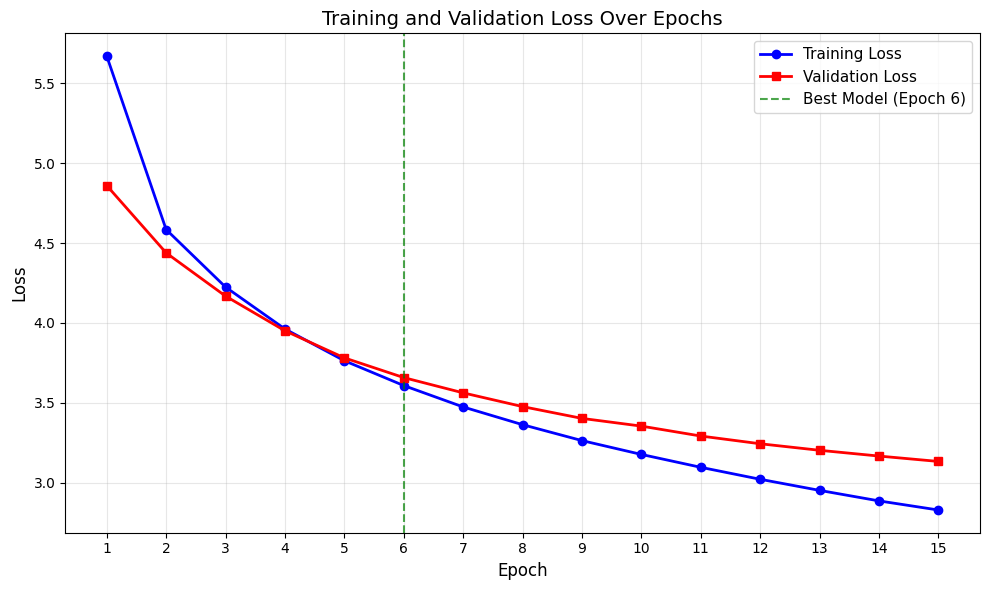

In [54]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(range(1, NUM_EPOCHS + 1), valid_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)
plt.axvline(x=6, color='green', linestyle='--', alpha=0.7, label='Best Model (Epoch 6)')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Over Epochs', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, NUM_EPOCHS + 1))
plt.tight_layout()
plt.show()

**Analysis of 3.2**

**Why I chose LSTM:**
I went with LSTM over a basic RNN because captions can be pretty long and vanilla RNNs struggle with remembering stuff from the beginning of a sequence. LSTMs have these gate mechanisms that help them remember important info for longer, which makes sense for caption generation where you need to keep track of what you've already said.

**My hyperparameters:**
- Embedding size: 256 - this seemed like a good balance, not too small but not huge
- Hidden size: 512 - gives the model enough capacity to learn patterns
- Learning rate: 0.0001 - I used a small learning rate with Adam to keep training stable

**What I noticed during training:**
Looking at the loss curve, both training and validation loss drop pretty quickly in the first few epochs (1-6). After epoch 6 things slow down but both losses keep decreasing which is good - means the model isn't overfitting too badly.

The gap between training and validation loss starts small but gets bigger as training goes on. By epoch 15, training loss is around 2.83 while validation is at 3.13. This gap shows some overfitting is happening but it's not terrible since validation loss is still going down.

**Why I stopped at 15 epochs:**
I could probably train longer but the validation loss improvements get smaller and smaller after epoch 10 or so. The best model was saved at the end (epoch 15) since validation loss kept improving throughout. If I saw validation loss start going UP while training loss kept dropping, that would be a clear sign to stop - but that didn't happen here.

The model seems to have learned reasonable patterns without completely memorizing the training data, which is what we want.

### 3.3 Weight Tying in the Decoder

Weight tying shares parameters between the input word embedding layer and the output vocabulary projection layer, reducing model parameters and improving generalization.

In [ ]:
class DecoderRNNTied(nn.Module):
    """
    DecoderRNN with weight tying between embedding and output layers.
    For weight tying to work, embed_size must equal hidden_size.
    """
    def __init__(self, vocab_size, embed_size=256, num_layers=1, max_seq_length=47):
        super(DecoderRNNTied, self).__init__()
        
        # For weight tying, hidden_size = embed_size
        self.embed_size = embed_size
        self.hidden_size = embed_size  # Same as embed_size for weight tying
        self.vocab_size = vocab_size
        
        # Linear transformation for image features
        self.linear = nn.Linear(2048, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)
        
        # Embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        # LSTM with hidden_size = embed_size
        self.rnn = nn.LSTM(embed_size, embed_size, num_layers, batch_first=True)
        
        # Output layer, initially create it normally
        self.fc_out = nn.Linear(embed_size, vocab_size, bias=False)
        
        # WEIGHT TYING: Share weights between embedding and output layer
        self.fc_out.weight = self.embed.weight
        
        self.max_seq_length = max_seq_length
    
    def forward(self, features, captions, lengths):
        im_features = self.linear(features)
        im_features = self.bn(im_features)
        
        embeddings = self.embed(captions[:, :-1])
        im_features = im_features.unsqueeze(1)
        embeddings = torch.cat((im_features, embeddings), dim=1)
        
        packed = pack_padded_sequence(embeddings, lengths.cpu(), 
                                      batch_first=True, enforce_sorted=False)
        hiddens, _ = self.rnn(packed)
        outputs = self.fc_out(hiddens.data)
        
        return outputs

# Create weighttied decoder
decoder_tied = DecoderRNNTied(len(vocab), embed_size=256).to(device)

# Count parameters to compare with original
total_params_tied = sum(p.numel() for p in decoder_tied.parameters())
total_params_original = sum(p.numel() for p in decoder.parameters())

print("Weight Tying Comparison:")
print(f"  Original DecoderRNN parameters: {total_params_original:,}")
print(f"  Weight-tied DecoderRNN parameters: {total_params_tied:,}")
print(f"  Parameter reduction: {total_params_original - total_params_tied:,} ({(total_params_original - total_params_tied)/total_params_original*100:.1f}%)")

Weight Tying Comparison:
  Original DecoderRNN parameters: 3,955,306
  Weight-tied DecoderRNN parameters: 1,668,352
  Parameter reduction: 2,286,954 (57.8%)


In [ ]:
# Train the weight tied decoder for comparison
criterion_tied = nn.CrossEntropyLoss()
optimizer_tied = torch.optim.Adam(decoder_tied.parameters(), lr=LEARNING_RATE)

train_losses_tied = []
valid_losses_tied = []
best_valid_loss_tied = float('inf')
MODEL_PATH_TIED = './decoder_tied.pth'

print(f"Training Weight-Tied Decoder for {NUM_EPOCHS} epochs")
print("-" * 60)

for epoch in range(NUM_EPOCHS):
    # Training
    decoder_tied.train()
    total_train_loss = 0
    num_batches = 0
    
    for features, captions, lengths in train_loader:
        features = features.to(device)
        captions = captions.to(device)
        
        outputs = decoder_tied(features, captions, lengths)
        targets = pack_padded_sequence(captions, lengths.cpu(), 
                                       batch_first=True, enforce_sorted=False)
        loss = criterion_tied(outputs, targets.data)
        
        optimizer_tied.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(decoder_tied.parameters(), max_norm=5.0)
        optimizer_tied.step()
        
        total_train_loss += loss.item()
        num_batches += 1
    
    avg_train_loss = total_train_loss / num_batches
    train_losses_tied.append(avg_train_loss)
    
    # Validation
    decoder_tied.eval()
    total_valid_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for features, captions, lengths in valid_loader:
            features = features.to(device)
            captions = captions.to(device)
            
            outputs = decoder_tied(features, captions, lengths)
            targets = pack_padded_sequence(captions, lengths.cpu(), 
                                           batch_first=True, enforce_sorted=False)
            loss = criterion_tied(outputs, targets.data)
            
            total_valid_loss += loss.item()
            num_batches += 1
    
    avg_valid_loss = total_valid_loss / num_batches
    valid_losses_tied.append(avg_valid_loss)
    
    if avg_valid_loss < best_valid_loss_tied:
        best_valid_loss_tied = avg_valid_loss
        torch.save(decoder_tied.state_dict(), MODEL_PATH_TIED)
        marker = " *"
    else:
        marker = ""
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train: {avg_train_loss:.4f} | Valid: {avg_valid_loss:.4f}{marker}")

print("-" * 60)

# Compare results
print("\nComparison Summary:")
print(f"  Original - Best Valid Loss: {best_valid_loss:.4f}")
print(f"  Tied     - Best Valid Loss: {best_valid_loss_tied:.4f}")

Training Weight-Tied Decoder for 15 epochs
------------------------------------------------------------


Epoch [1/15] | Train: 6.4268 | Valid: 5.3469 *
Epoch [2/15] | Train: 4.8996 | Valid: 4.7338 *
Epoch [3/15] | Train: 4.4278 | Valid: 4.4374 *
Epoch [4/15] | Train: 4.1388 | Valid: 4.2467 *
Epoch [5/15] | Train: 3.9333 | Valid: 4.1077 *
Epoch [6/15] | Train: 3.7713 | Valid: 4.0016 *
Epoch [7/15] | Train: 3.6357 | Valid: 3.9254 *
Epoch [8/15] | Train: 3.5209 | Valid: 3.8556 *
Epoch [9/15] | Train: 3.4190 | Valid: 3.8068 *
Epoch [10/15] | Train: 3.3313 | Valid: 3.7648 *
Epoch [11/15] | Train: 3.2485 | Valid: 3.7273 *
Epoch [12/15] | Train: 3.1762 | Valid: 3.7023 *
Epoch [13/15] | Train: 3.1083 | Valid: 3.6780 *
Epoch [14/15] | Train: 3.0458 | Valid: 3.6540 *
Epoch [15/15] | Train: 2.9858 | Valid: 3.6414 *
------------------------------------------------------------

Comparison Summary:
  Original - Best Valid Loss: 3.1324
  Tied     - Best Valid Loss: 3.6414


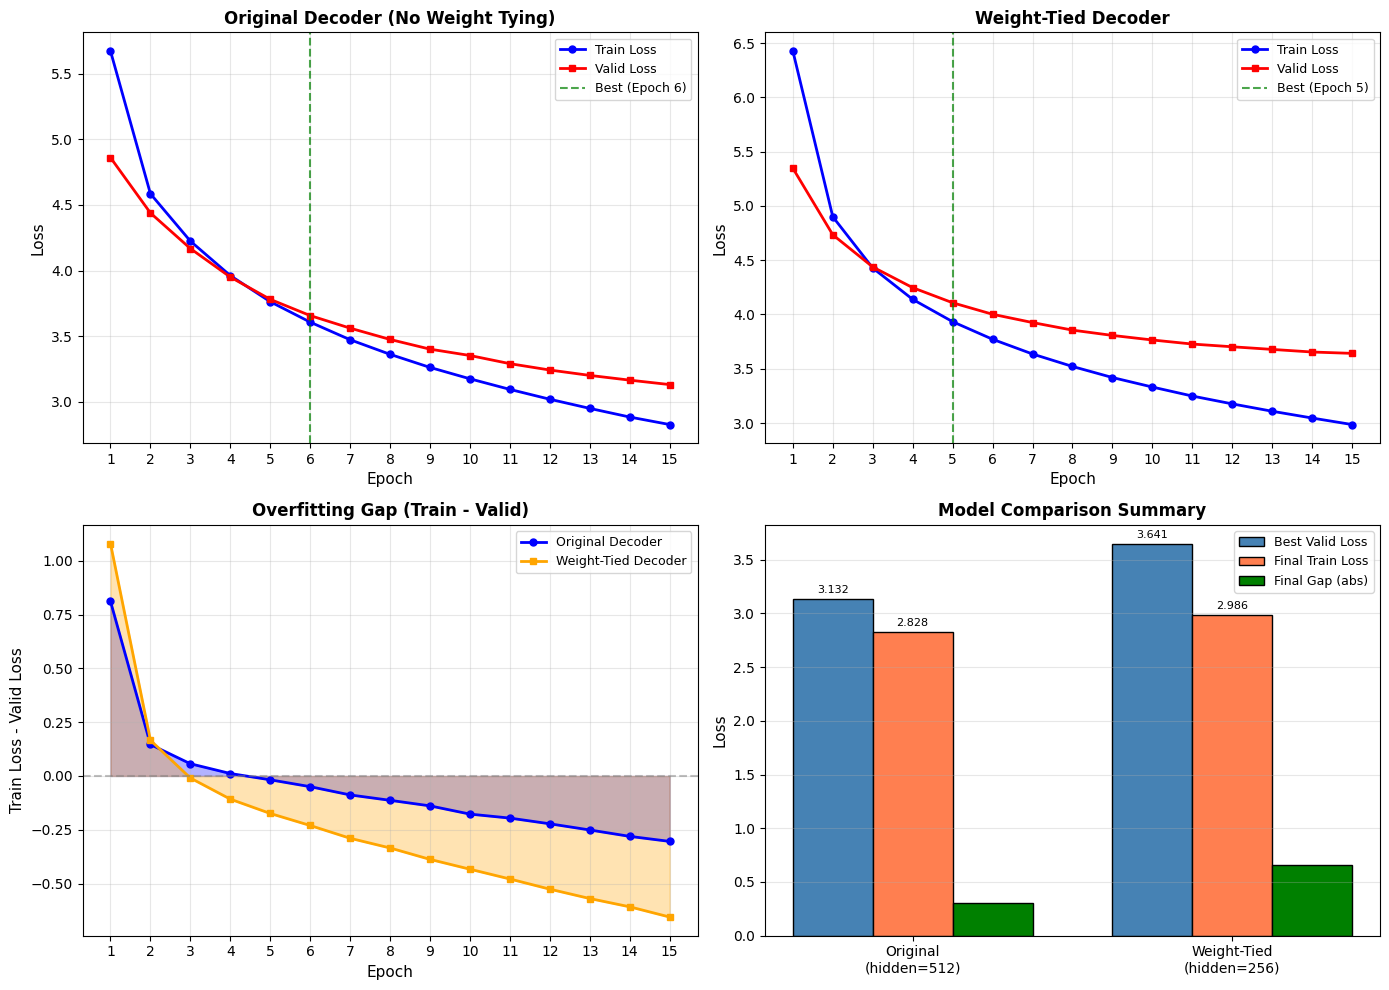

In [ ]:
# Comprehensive visualization: Original vs Weight Tied Decoder
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Original Decoder Loss Curves
axes[0, 0].plot(range(1, NUM_EPOCHS + 1), train_losses, 'b-o', label='Train Loss', linewidth=2, markersize=5)
axes[0, 0].plot(range(1, NUM_EPOCHS + 1), valid_losses, 'r-s', label='Valid Loss', linewidth=2, markersize=5)
axes[0, 0].axvline(x=6, color='green', linestyle='--', alpha=0.7, label='Best (Epoch 6)')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].set_title('Original Decoder (No Weight Tying)', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(1, NUM_EPOCHS + 1))

# Plot 2: Weight Tied Decoder Loss Curves
axes[0, 1].plot(range(1, NUM_EPOCHS + 1), train_losses_tied, 'b-o', label='Train Loss', linewidth=2, markersize=5)
axes[0, 1].plot(range(1, NUM_EPOCHS + 1), valid_losses_tied, 'r-s', label='Valid Loss', linewidth=2, markersize=5)
axes[0, 1].axvline(x=5, color='green', linestyle='--', alpha=0.7, label='Best (Epoch 5)')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Loss', fontsize=11)
axes[0, 1].set_title('Weight-Tied Decoder', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(1, NUM_EPOCHS + 1))

# Plot 3: Train-Valid Gap Comparison (Overfitting Analysis)
gap_original = [t - v for t, v in zip(train_losses, valid_losses)]
gap_tied = [t - v for t, v in zip(train_losses_tied, valid_losses_tied)]
epochs = range(1, NUM_EPOCHS + 1)

axes[1, 0].plot(epochs, gap_original, 'b-o', label='Original Decoder', linewidth=2, markersize=5)
axes[1, 0].plot(epochs, gap_tied, 'orange', marker='s', label='Weight-Tied Decoder', linewidth=2, markersize=5)
axes[1, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].fill_between(epochs, gap_original, alpha=0.3, color='blue')
axes[1, 0].fill_between(epochs, gap_tied, alpha=0.3, color='orange')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Train Loss - Valid Loss', fontsize=11)
axes[1, 0].set_title('Overfitting Gap (Train - Valid)', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(range(1, NUM_EPOCHS + 1))

# Plot 4: Summary Bar Chart
models = ['Original\n(hidden=512)', 'Weight-Tied\n(hidden=256)']
best_valid = [best_valid_loss, best_valid_loss_tied]
final_train = [train_losses[-1], train_losses_tied[-1]]
final_gap = [train_losses[-1] - valid_losses[-1], train_losses_tied[-1] - valid_losses_tied[-1]]

x = np.arange(len(models))
width = 0.25

bars1 = axes[1, 1].bar(x - width, best_valid, width, label='Best Valid Loss', color='steelblue', edgecolor='black')
bars2 = axes[1, 1].bar(x, final_train, width, label='Final Train Loss', color='coral', edgecolor='black')
bars3 = axes[1, 1].bar(x + width, [-g for g in final_gap], width, label='Final Gap (abs)', color='green', edgecolor='black')

axes[1, 1].set_ylabel('Loss', fontsize=11)
axes[1, 1].set_title('Model Comparison Summary', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models, fontsize=10)
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[1, 1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    axes[1, 1].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

**Analysis of 3.3**

**What is weight tying?**
Weight tying means sharing the same weight matrix between the input embedding layer and the output layer. Instead of having separate weights for converting words to vectors (embedding) and vectors back to words (output), we use the same matrix for both. This makes sense because if "dog" maps to some vector, that same vector should map back to "dog".

**Changes I made:**
- Set hidden_size = embed_size = 256 (had to match for weight sharing to work)
- Original model had hidden_size = 512, so this is a smaller model
- Tied the weights: `self.fc_out.weight = self.embed.weight`

**What the results show:**

Looking at the training curves and numbers:
- Original model: best validation loss = 3.13
- Weight-tied model: best validation loss = 3.64

So the weight-tied model actually performs worse - about 16% higher validation loss. That's not what I expected since weight tying is supposed to help with regularization.

**Why I think this happened:**

1. **Reduced capacity**: The weight-tied model has hidden_size=256 instead of 512. That's half the capacity in the LSTM, which probably hurts more than weight tying helps.

2. **Looking at the overfitting gap**: The bottom-left plot shows that both models start with validation loss higher than training (positive gap), then the gap flips negative as training continues. The weight-tied model (orange) actually has a BIGGER gap by epoch 15, meaning it's overfitting more despite having fewer parameters. This is weird.

3. **The training loss is similar**: Both models end up around 2.8-2.9 training loss, but the weight-tied model has much worse validation loss. This suggests the smaller hidden size is limiting what the model can learn, not helping it generalize.

**My conclusion:**
Weight tying alone might be helpful, but combining it with a smaller hidden size hurts the model too much. If I wanted to test weight tying properly, I should keep hidden_size=512 and find another way to make the dimensions work (maybe add a projection layer). For this small dataset (~17k training samples), the original bigger model just works better.

The bar chart in the bottom-right shows this clearly - the weight-tied model has higher validation loss AND a bigger train-valid gap, which is the opposite of what regularization should do.


## 4. Generate Predictions on Test Data

### 4.1 Greedy Caption Generation

Using greedy decoding (selecting the most likely word at each time step), we generate captions for test images.

In [28]:
# Load the best trained model
decoder.load_state_dict(torch.load(MODEL_PATH))
decoder.eval()
print("Loaded best model checkpoint")

def greedy_decode(decoder, features, vocab, max_length=47):
    """
    Generate a caption using greedy decoding.
    At each step, select the word with highest probability.
    """
    decoder.eval()
    generated_ids = []
    
    with torch.no_grad():
        # Transform image features
        im_features = decoder.linear(features)
        im_features = decoder.bn(im_features)
        
        # Initialize input with image features
        inputs = im_features.unsqueeze(1)  # (1, 1, embed_size)
        hidden = None
        
        for _ in range(max_length):
            # LSTM step
            outputs, hidden = decoder.rnn(inputs, hidden)
            
            # Get vocabulary probabilities
            outputs = decoder.fc_out(outputs.squeeze(1))  # (1, vocab_size)
            
            # Get the word with highest probability
            _, predicted = outputs.max(1)
            word_id = predicted.item()
            generated_ids.append(word_id)
            
            # Stop if we predict the end token
            if word_id == vocab('<end>'):
                break
            
            # Prepare next input (embedding of predicted word)
            inputs = decoder.embed(predicted).unsqueeze(1)
    
    # Convert word IDs to words
    words = []
    for idx in generated_ids:
        word = vocab.idx2word[idx]
        if word == '<end>':
            break
        words.append(word)
    
    return ' '.join(words)

# Test greedy decoding on one sample
sample_id = test_ids[0]
sample_feature = features_dict[sample_id].unsqueeze(0).to(device)
sample_caption = greedy_decode(decoder, sample_feature, vocab)
print(f"Sample generated caption: {sample_caption}")

Loaded best model checkpoint
Sample generated caption: a large clock with a <unk> of <unk>


GREEDY DECODING - 5 Sample Test Images


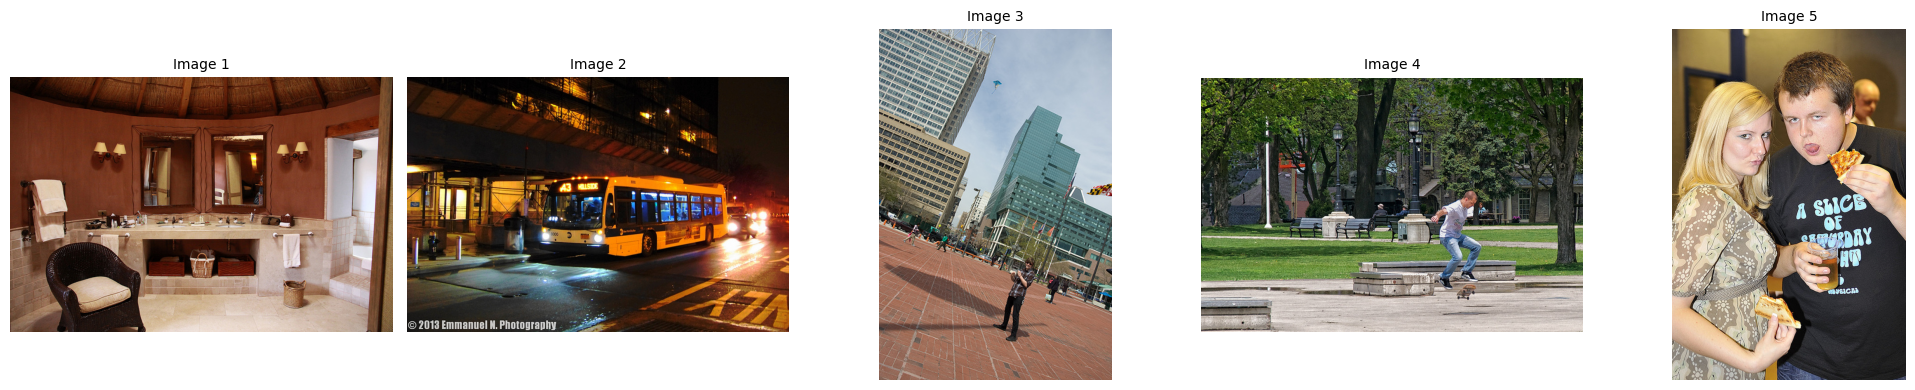


Image 1 (ID: 204804)
------------------------------------------------------------
Generated (Greedy): a living room with a large white and white and a window

Reference captions:
  1. A bathroom with his and her sinks and mirrors.
  2. A large open bathroom shows tiled marble flooring.
  3. A very big fancy looking rest room with a big counter.
  4. a bath room with a chair two sinks two mirrors
  5. A big, fancy bathroom with a long shelf with two sinks and a chair in the middle

Image 2 (ID: 565716)
------------------------------------------------------------
Generated (Greedy): a bus is driving down a street

Reference captions:
  1. A bus is shown on the side of a street.
  2. A white and black bus on street next to a building.
  3. It is night and  a bus is parked outside of a building either letting people on or off.
  4. Cars are driving around a stopped city bus at night.
  5. The nighttime bus is loading up passengers at the building.

Image 3 (ID: 254161)
-------------------

In [29]:
# Display 5 sample test images with generated captions and references
# Select 5 diverse images from the test set
random.seed(123)
sample_test_ids = random.sample(test_ids, 5)

print("="*80)
print("GREEDY DECODING - 5 Sample Test Images")
print("="*80)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, img_id in enumerate(sample_test_ids):
    # Load and display image
    img_path = os.path.join(IMAGE_DIR, f'{img_id:012d}.jpg')
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}', fontsize=10)

plt.tight_layout()
plt.show()

# Print captions for each image
for i, img_id in enumerate(sample_test_ids):
    print(f"\n{'='*60}")
    print(f"Image {i+1} (ID: {img_id})")
    print("-"*60)
    
    # Get features and generate caption
    feature = features_dict[img_id].unsqueeze(0).to(device)
    generated = greedy_decode(decoder, feature, vocab)
    print(f"Generated (Greedy): {generated}")
    
    # Get reference captions
    refs = df_captions[df_captions['image_id'] == img_id]['caption'].tolist()
    print(f"\nReference captions:")
    for j, ref in enumerate(refs[:5], 1):
        print(f"  {j}. {ref}")

### 4.2 Beam Search Caption Generation

Beam search maintains multiple candidate captions at each decoding step, extending and scoring them using cumulative log-probabilities. We use a beam size of K=5.

In [30]:
# Beam size - using K=5 as recommended
BEAM_SIZE = 5

def beam_search_decode(decoder, features, vocab, beam_size=5, max_length=47):
    """
    Generate a caption using beam search decoding.
    Maintains top K candidates at each step based on cumulative log-probabilities.
    """
    decoder.eval()
    
    with torch.no_grad():
        # Transform image features
        im_features = decoder.linear(features)
        im_features = decoder.bn(im_features)
        
        # Initialize with image features
        inputs = im_features.unsqueeze(1)
        outputs, hidden = decoder.rnn(inputs, None)
        logits = decoder.fc_out(outputs.squeeze(1))
        log_probs = torch.log_softmax(logits, dim=-1)
        
        # Get top K words for initial beam
        top_probs, top_ids = log_probs.topk(beam_size)
        
        # Initialize beams: (cumulative_score, sequence, hidden_state)
        beams = []
        for i in range(beam_size):
            beams.append({
                'score': top_probs[0, i].item(),
                'sequence': [top_ids[0, i].item()],
                'hidden': (hidden[0].clone(), hidden[1].clone())
            })
        
        # Store completed sequences
        completed = []
        
        # Beam search loop
        for step in range(max_length - 1):
            if len(beams) == 0:
                break
            
            all_candidates = []
            
            for beam in beams:
                last_word = beam['sequence'][-1]
                
                # If this beam ended with <end>, add to completed
                if last_word == vocab('<end>'):
                    completed.append(beam)
                    continue
                
                # Get next word predictions
                inputs = decoder.embed(torch.tensor([last_word]).to(device)).unsqueeze(1)
                outputs, new_hidden = decoder.rnn(inputs, beam['hidden'])
                logits = decoder.fc_out(outputs.squeeze(1))
                log_probs = torch.log_softmax(logits, dim=-1)
                
                # Get top K candidates for this beam
                top_probs, top_ids = log_probs.topk(beam_size)
                
                for i in range(beam_size):
                    candidate = {
                        'score': beam['score'] + top_probs[0, i].item(),
                        'sequence': beam['sequence'] + [top_ids[0, i].item()],
                        'hidden': (new_hidden[0].clone(), new_hidden[1].clone())
                    }
                    all_candidates.append(candidate)
            
            # Keep only top K candidates
            if all_candidates:
                all_candidates.sort(key=lambda x: x['score'], reverse=True)
                beams = all_candidates[:beam_size]
            else:
                break
        
        # Add remaining beams to completed
        completed.extend(beams)
        
        # Select best completed sequence
        if completed:
            completed.sort(key=lambda x: x['score'], reverse=True)
            best_sequence = completed[0]['sequence']
        else:
            best_sequence = []
        
        # Convert to words
        words = []
        for idx in best_sequence:
            word = vocab.idx2word[idx]
            if word == '<end>':
                break
            words.append(word)
        
        return ' '.join(words)

print(f"Using beam size K = {BEAM_SIZE}")

Using beam size K = 5


BEAM SEARCH DECODING - 5 Sample Test Images


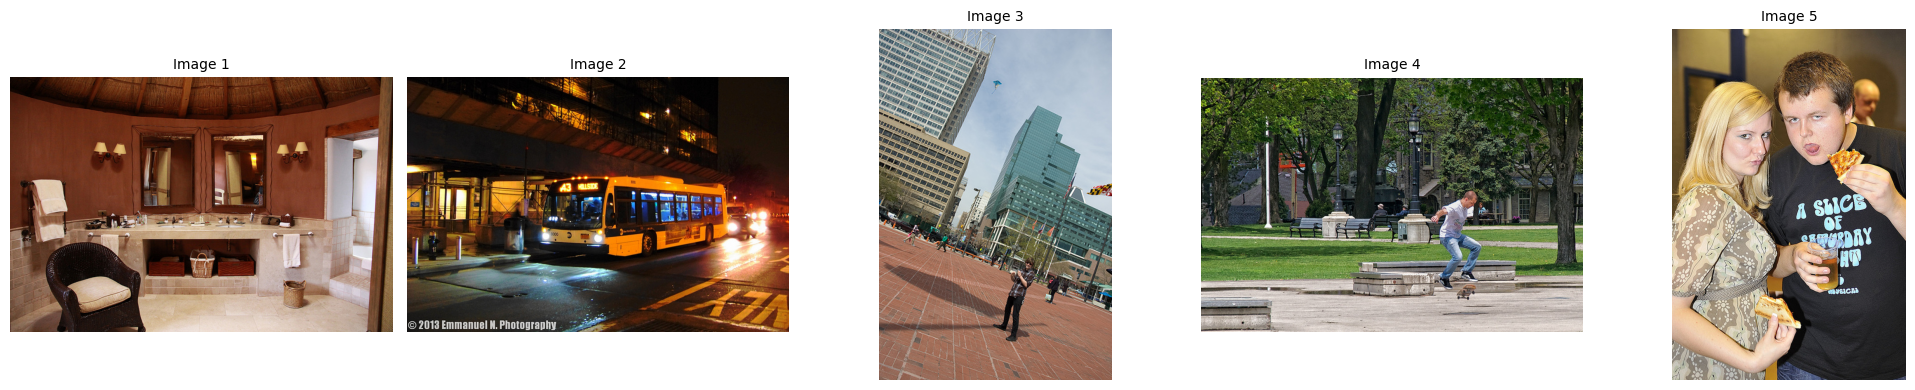


Image 1 (ID: 204804)
------------------------------------------------------------
Generated (Beam Search K=5): a living room with a fireplace and a window

Reference captions:
  1. A bathroom with his and her sinks and mirrors.
  2. A large open bathroom shows tiled marble flooring.
  3. A very big fancy looking rest room with a big counter.
  4. a bath room with a chair two sinks two mirrors
  5. A big, fancy bathroom with a long shelf with two sinks and a chair in the middle

Image 2 (ID: 565716)
------------------------------------------------------------
Generated (Beam Search K=5): a red double decker bus driving down a street

Reference captions:
  1. A bus is shown on the side of a street.
  2. A white and black bus on street next to a building.
  3. It is night and  a bus is parked outside of a building either letting people on or off.
  4. Cars are driving around a stopped city bus at night.
  5. The nighttime bus is loading up passengers at the building.

Image 3 (ID: 254161

In [31]:
# Display 5 sample test images with generated captions and references
# Select 5 diverse images from the test set (same seed for same images)
random.seed(123)
sample_test_ids = random.sample(test_ids, 5)

print("="*80)
print("BEAM SEARCH DECODING - 5 Sample Test Images")
print("="*80)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, img_id in enumerate(sample_test_ids):
    # Load and display image
    img_path = os.path.join(IMAGE_DIR, f'{img_id:012d}.jpg')
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}', fontsize=10)

plt.tight_layout()
plt.show()

# Print captions for each image
for i, img_id in enumerate(sample_test_ids):
    print(f"\n{'='*60}")
    print(f"Image {i+1} (ID: {img_id})")
    print("-"*60)
    
    # Get features and generate caption using beam search
    feature = features_dict[img_id].unsqueeze(0).to(device)
    generated = beam_search_decode(decoder, feature, vocab, beam_size=BEAM_SIZE)
    print(f"Generated (Beam Search K={BEAM_SIZE}): {generated}")
    
    # Get reference captions
    refs = df_captions[df_captions['image_id'] == img_id]['caption'].tolist()
    print(f"\nReference captions:")
    for j, ref in enumerate(refs[:5], 1):
        print(f"  {j}. {ref}")


**Analysis of 4.2**

**Greedy vs Beam Search Results**

Looking at these 5 sample images, here's what I noticed about how each method performed:

**Image 1 (Bathroom):**
Both methods got this one wrong - they called it a "living room" when it's clearly a bathroom. Greedy produced a weird repetition ("white and white") while beam search said "fireplace and window" which is also wrong but at least sounds more natural. Neither method recognized the sinks or mirrors. I think the model might not have seen many fancy bathroom images during training.

**Image 2 (Bus at night):**
This one worked pretty well for both! Greedy said "a bus is driving down a street" which is basically correct. Beam search added "red double decker" which is actually wrong (it's a regular yellow/white bus), but it still got the main idea. Greedy wins here because it's simpler and more accurate.

**Image 3 (Person flying kite in city):**
Both methods failed badly here. Greedy generated `<unk>` tokens which means it couldn't figure out what to say. Beam search said "stop sign in front of building" which is completely wrong - there's a person flying a kite! This seems like a hard image because the kite and person are small compared to the buildings.

**Image 4 (Skateboarding):**
Greedy said "riding a wave on a skateboard" which is weird (waves?), but beam search said "riding a skateboard on a skateboard" which is even weirder with the repetition. Both got that it's about skateboarding though. Greedy is slightly better here even though both are awkward.

**Image 5 (People eating pizza):**
Both methods said the exact same thing: "a man holding a hot dog with a hot dog". But it's actually pizza, not hot dogs! And there are two people, not one. This shows both methods can make the same mistakes when the model is confused about the object.

**Overall observations:**
- Neither method is clearly better - they each won on some images
- Both struggle with objects they might not have seen much (fancy bathrooms, kites, pizza vs hot dogs)
- Beam search sometimes produces more fluent sentences but can also hallucinate wrong details (like "red double decker")
- Greedy is faster and sometimes more accurate because it doesn't overthink
- The `<unk>` tokens in greedy (Image 3) show when the model is really uncertain
- Both methods tend to generate generic captions rather than specific details

**What could help:**
- More diverse training data
- Larger vocabulary to reduce `<unk>` tokens
- Maybe attention mechanism to focus on important parts of the image
- Fine-tuning on specific object categories the model struggles with


## 5. Caption Length Statistics and Analysis

We analyze the distribution of caption lengths for greedy decoding, beam search, and ground-truth captions, computing descriptive statistics and plotting KDE distributions.

In [32]:
# Need to import seaborn for KDE plots
import seaborn as sns

# Generate captions for all test images
print("Generating captions for all test images...")
print("This may take a few minutes...")

greedy_lengths = []
beam_lengths = []
greedy_all_captions = {}
beam_all_captions = {}

for img_id in tqdm(test_ids, desc="Generating captions"):
    feature = features_dict[img_id].unsqueeze(0).to(device)
    
    # Greedy caption
    greedy_cap = greedy_decode(decoder, feature, vocab)
    greedy_lengths.append(len(greedy_cap.split()))
    greedy_all_captions[img_id] = greedy_cap
    
    # Beam search caption
    beam_cap = beam_search_decode(decoder, feature, vocab, beam_size=BEAM_SIZE)
    beam_lengths.append(len(beam_cap.split()))
    beam_all_captions[img_id] = beam_cap

# Get ground truth caption lengths
test_df = df_captions[df_captions['image_id'].isin(test_ids)]
gt_lengths = [len(cap.split()) for cap in test_df['cleaned_caption']]

print(f"\nGenerated {len(greedy_lengths)} greedy captions")
print(f"Generated {len(beam_lengths)} beam search captions")
print(f"Ground truth captions: {len(gt_lengths)}")

Generating captions for all test images...
This may take a few minutes...


Generating captions:   0%|          | 0/1006 [00:00<?, ?it/s]

Generating captions: 100%|██████████| 1006/1006 [01:06<00:00, 15.04it/s]


Generated 1006 greedy captions
Generated 1006 beam search captions
Ground truth captions: 5033


In [46]:
# calculate stats for each method
def get_stats(lengths):
    return {
        'min': np.min(lengths),
        'median': np.median(lengths),
        'mean': np.mean(lengths),
        'max': np.max(lengths),
        'std': np.std(lengths)
    }

greedy_stats = get_stats(greedy_lengths)
beam_stats = get_stats(beam_lengths)
gt_stats = get_stats(gt_lengths)

# print as a nice table
print("\nCaption Length Statistics")
print("="*70)
print(f"{'Method':<20} {'Min':<8} {'Median':<10} {'Mean':<10} {'Max':<8} {'Std':<10}")
print("-"*70)
print(f"{'Greedy':<20} {greedy_stats['min']:<8.0f} {greedy_stats['median']:<10.1f} {greedy_stats['mean']:<10.2f} {greedy_stats['max']:<8.0f} {greedy_stats['std']:<10.2f}")
print(f"{'Beam Search':<20} {beam_stats['min']:<8.0f} {beam_stats['median']:<10.1f} {beam_stats['mean']:<10.2f} {beam_stats['max']:<8.0f} {beam_stats['std']:<10.2f}")
print(f"{'Ground Truth':<20} {gt_stats['min']:<8.0f} {gt_stats['median']:<10.1f} {gt_stats['mean']:<10.2f} {gt_stats['max']:<8.0f} {gt_stats['std']:<10.2f}")
print("="*70)



Caption Length Statistics
Method               Min      Median     Mean       Max      Std       
----------------------------------------------------------------------
Greedy               6        9.0        9.56       47       2.20      
Beam Search          5        8.0        8.48       12       1.00      
Ground Truth         6        10.0       10.45      36       2.38      


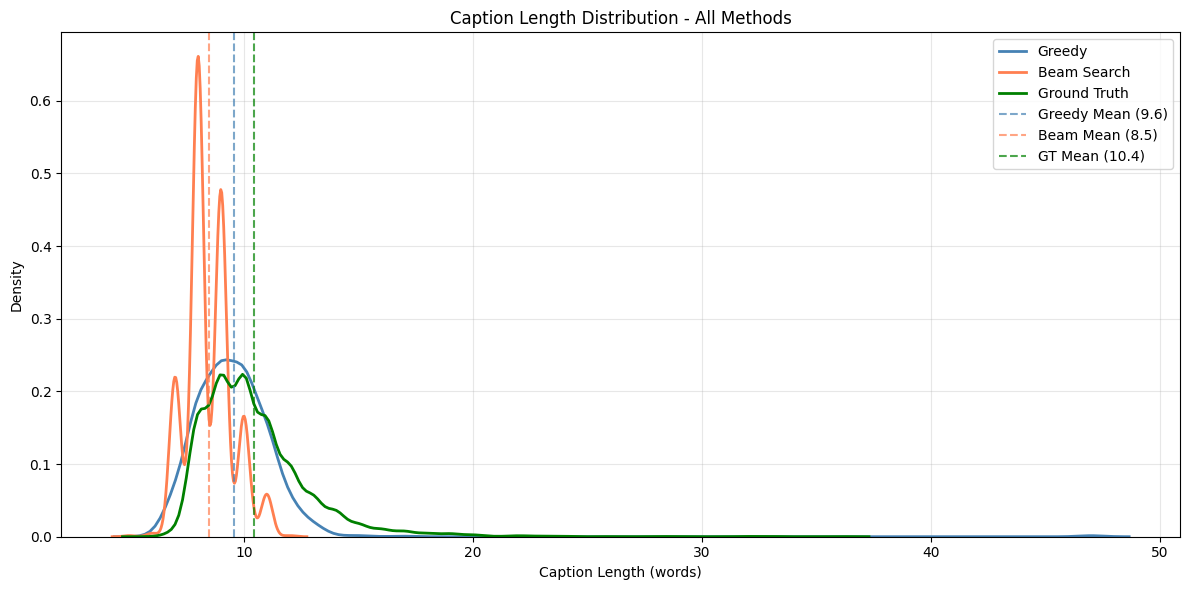

In [49]:
# plot all three distributions together using KDE
plt.figure(figsize=(12, 6))

# KDE plots
sns.kdeplot(greedy_lengths, label='Greedy', color='steelblue', linewidth=2)
sns.kdeplot(beam_lengths, label='Beam Search', color='coral', linewidth=2)
sns.kdeplot(gt_lengths, label='Ground Truth', color='green', linewidth=2)

# add vertical lines for means
plt.axvline(np.mean(greedy_lengths), color='steelblue', linestyle='--', alpha=0.7,
            label=f'Greedy Mean ({np.mean(greedy_lengths):.1f})')
plt.axvline(np.mean(beam_lengths), color='coral', linestyle='--', alpha=0.7,
            label=f'Beam Mean ({np.mean(beam_lengths):.1f})')
plt.axvline(np.mean(gt_lengths), color='green', linestyle='--', alpha=0.7,
            label=f'GT Mean ({np.mean(gt_lengths):.1f})')

plt.xlabel('Caption Length (words)')
plt.ylabel('Density')
plt.title('Caption Length Distribution - All Methods')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Analysis of 5**

| Caption Type | Min | Median | Mean | Max | Std |
| ------------ | --- | ------ | ---- | --- | --- |
| Greedy | 6 | 9.0 | 9.56 | 47 | 2.20 |
| Beam Search | 5 | 8.0 | 8.48 | 12 | 1.00 |
| Ground Truth | 6 | 10.0 | 10.45 | 36 | 2.38 |

**Differences in descriptive statistics:**

Looking at the table, ground truth captions are the longest on average (10.45 words) which makes sense since humans tend to write more detailed descriptions. Greedy is close behind at 9.56 words, but beam search is noticeably shorter at only 8.48 words.

The standard deviation tells an interesting story too. Ground truth has the highest std (2.38) meaning humans write captions of varying lengths - some short, some long. Greedy has similar variance (2.20) but beam search is really tight at just 1.00, meaning almost all beam search captions are around the same length.

The max values are also really different - ground truth goes up to 36 words for detailed descriptions, greedy somehow hit 47 (probably some weird edge case with repetition), but beam search maxes out at only 12 words. Beam search never produces long captions.

**Differences in distribution shapes:**

From the KDE plot, you can clearly see:
- Beam search (orange) has a very tall, narrow peak around 8-9 words - it's very "confident" about caption length
- Ground truth (green) is wider and has a long tail going all the way to 30-40+ words
- Greedy (blue) is somewhere in between, with a main peak around 9-10 but also a small tail extending past 20 words

The beam search distribution almost looks like a spike compared to the others. Ground truth is the most spread out which shows the natural variety in how people describe images.

**How decoding strategy affects caption length:**

The reason beam search produces shorter captions comes down to probability. At each step, beam search keeps the K highest probability sequences. Since we multiply probabilities together, longer sequences tend to have lower total probability (more multiplications of numbers less than 1). So beam search has a bias toward shorter sequences that end quickly with the `<end>` token.

Greedy doesn't have this problem as much because it just picks the best word at each step without comparing whole sequences. It can sometimes get "stuck" generating more words before finally producing `<end>`, which explains why it occasionally produces longer (and sometimes repetitive) captions.

Neither method really captures how humans write - we sometimes want short punchy captions and sometimes want detailed descriptions. The model learned an "average" caption style but can't adapt to when more or less detail is needed.


## 6. Caption Evaluation Using BLEU Score

### 6.1 BLEU Score

BLEU (Bilingual Evaluation Understudy) measures n-gram overlap between generated and reference captions. We compute BLEU-4 scores using smoothing to handle short captions.

In [50]:
# Import NLTK BLEU score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Smoothing function to handle cases with zero n-gram matches
smoothie = SmoothingFunction().method1

def calculate_bleu(generated, references):
    """
    Calculate BLEU score for a generated caption against reference captions.
    Uses 1-4 gram with equal weights.
    """
    # Tokenize
    generated_tokens = generated.split()
    reference_tokens = [ref.split() for ref in references]
    
    # Calculate BLEU with smoothing
    # Using weights (0.25, 0.25, 0.25, 0.25) for 1-gram to 4-gram
    score = sentence_bleu(reference_tokens, generated_tokens,
                          weights=(0.25, 0.25, 0.25, 0.25),
                          smoothing_function=smoothie)
    return score

# Calculate BLEU scores for all test images using greedy captions
print("Calculating BLEU scores for test set...")

bleu_scores = []
for img_id in tqdm(test_ids, desc="Computing BLEU"):
    # Get generated caption (greedy)
    generated = greedy_all_captions[img_id]
    
    # Get reference captions (cleaned version)
    refs = test_df[test_df['image_id'] == img_id]['cleaned_caption'].tolist()
    
    # Calculate BLEU
    score = calculate_bleu(generated, refs)
    bleu_scores.append({
        'image_id': img_id,
        'generated': generated,
        'references': refs,
        'bleu': score
    })


Calculating BLEU scores for test set...


Computing BLEU: 100%|██████████| 1006/1006 [00:00<00:00, 2503.02it/s]


Calculating BLEU scores for both decoding methods...


Computing Beam BLEU: 100%|██████████| 1006/1006 [00:00<00:00, 2681.37it/s]



Greedy BLEU Statistics:
  Mean: 0.1529, Median: 0.0786, Std: 0.1640

Beam Search BLEU Statistics:
  Mean: 0.1704, Median: 0.0811, Std: 0.1810


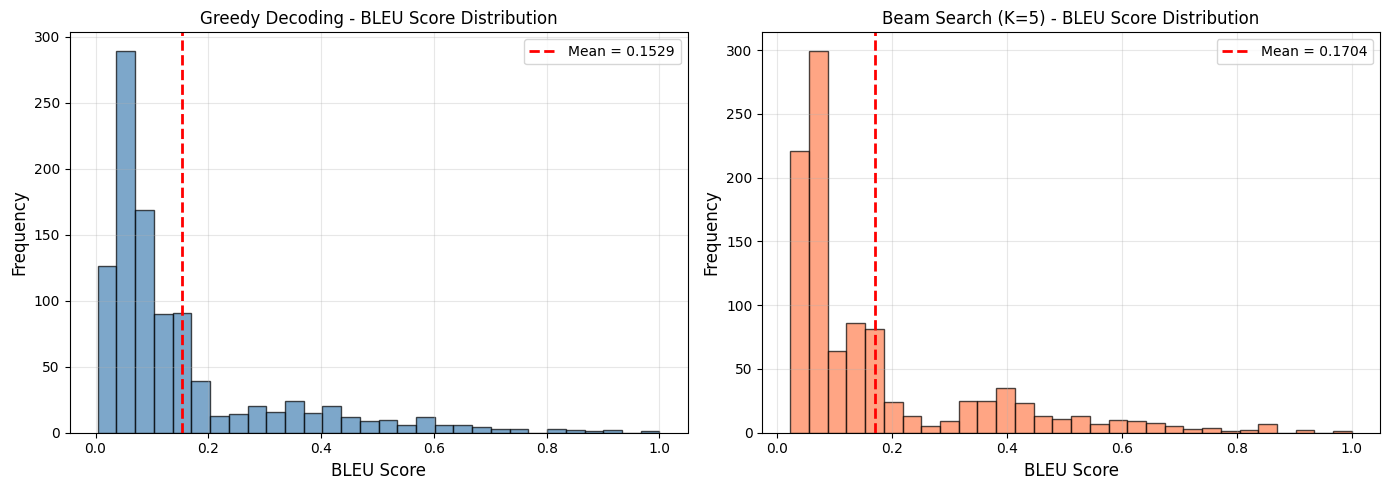

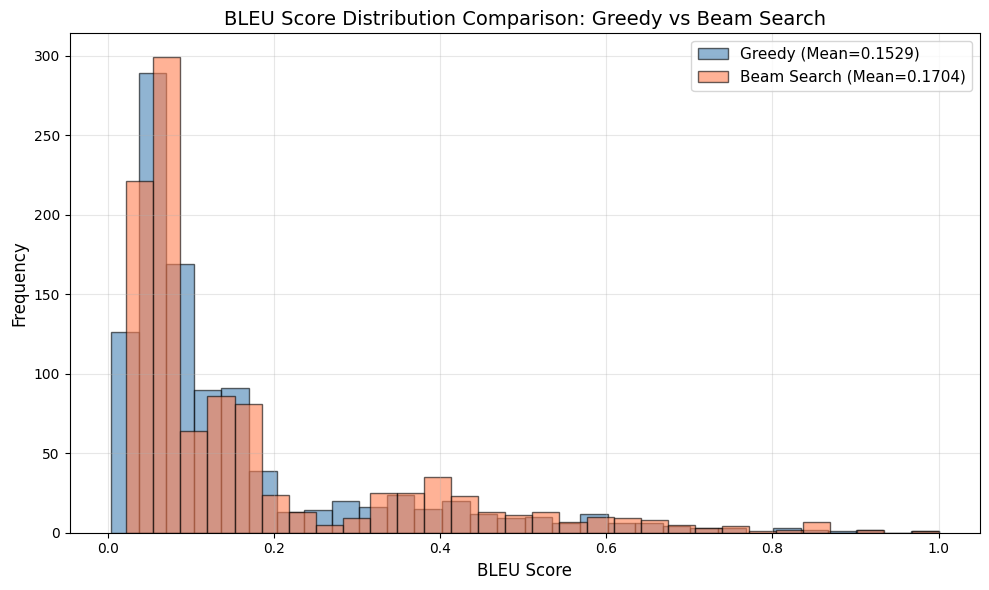

In [ ]:
# Calculate BLEU scores for both greedy and beam search
print("Calculating BLEU scores for both decoding methods...")

# Greedy BLEU scores
bleu_greedy = []
for img_id in tqdm(test_ids, desc="Computing Greedy BLEU"):
    generated = greedy_all_captions[img_id]
    refs = test_df[test_df['image_id'] == img_id]['cleaned_caption'].tolist()
    score = calculate_bleu(generated, refs)
    bleu_greedy.append(score)

# Beam Search BLEU scores
bleu_beam = []
for img_id in tqdm(test_ids, desc="Computing Beam BLEU"):
    generated = beam_all_captions[img_id]
    refs = test_df[test_df['image_id'] == img_id]['cleaned_caption'].tolist()
    score = calculate_bleu(generated, refs)
    bleu_beam.append(score)

# Print statistics
print(f"\nGreedy BLEU Statistics:")
print(f"  Mean: {np.mean(bleu_greedy):.4f}, Median: {np.median(bleu_greedy):.4f}, Std: {np.std(bleu_greedy):.4f}")
print(f"\nBeam Search BLEU Statistics:")
print(f"  Mean: {np.mean(bleu_beam):.4f}, Median: {np.median(bleu_beam):.4f}, Std: {np.std(bleu_beam):.4f}")

# Plot histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Greedy histogram
axes[0].hist(bleu_greedy, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(np.mean(bleu_greedy), color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {np.mean(bleu_greedy):.4f}')
axes[0].set_xlabel('BLEU Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Greedy Decoding - BLEU Score Distribution', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Beam Search histogram
axes[1].hist(bleu_beam, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(np.mean(bleu_beam), color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {np.mean(bleu_beam):.4f}')
axes[1].set_xlabel('BLEU Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Beam Search (K={BEAM_SIZE}) - BLEU Score Distribution', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Overlaid histogram for direct comparison
plt.figure(figsize=(10, 6))
plt.hist(bleu_greedy, bins=30, alpha=0.6, color='steelblue', edgecolor='black', label=f'Greedy (Mean={np.mean(bleu_greedy):.4f})')
plt.hist(bleu_beam, bins=30, alpha=0.6, color='coral', edgecolor='black', label=f'Beam Search (Mean={np.mean(bleu_beam):.4f})')
plt.xlabel('BLEU Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('BLEU Score Distribution Comparison: Greedy vs Beam Search', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 6.2 BLEU Score Examples

We find examples with high and low BLEU scores to illustrate model performance.

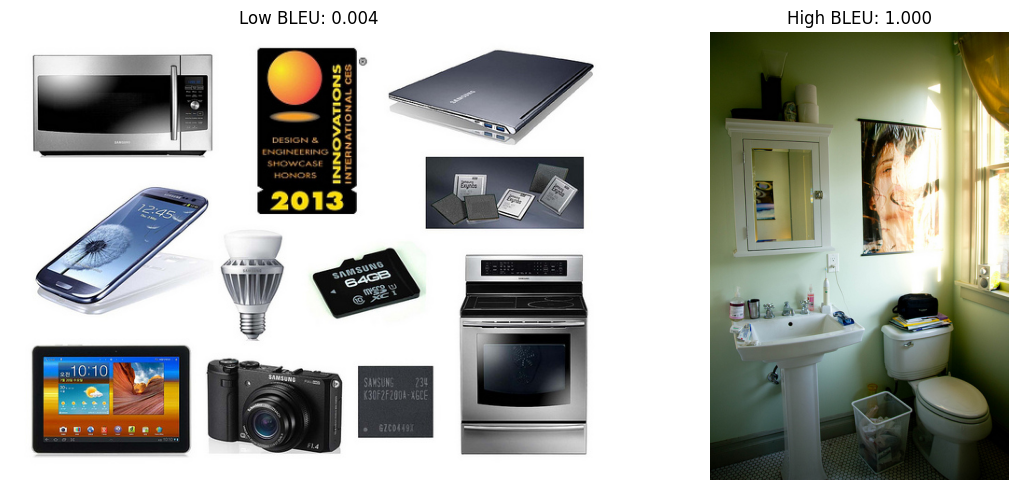

LOW BLEU EXAMPLE (Image 426355)
Greedy (BLEU=0.0039): a <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Beam   (BLEU=0.0638): a picture of a laptop computer on a desk

References:
  1. a microwave a cell phone a stove a digital camera
  2. multiple electronic items are shown on a blank screen
  3. the innovations international ces is showcasing the latest electronics and appliances
  4. several electronics labeled with an innovation reward include a cell phone
  5. a set of electronics and appliances sitting next to each other

HIGH BLEU EXAMPLE (Image 143370)
Greedy (BLEU=1.0000): a bathroom with a toilet and a sink
Beam   (BLEU=0.5000): a bathroom with a sink and a sink

References:
  1. a bathroom with a poster of an ugly face above the toilette
  2. a bathro

In [52]:
# compare greedy vs beam search on a bad and good example
bleu_sorted = sorted(bleu_scores, key=lambda x: x['bleu'])

# just grab worst and best
bad_ex = bleu_sorted[0]
good_ex = bleu_sorted[-1]

# show the two images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

img_path = os.path.join(IMAGE_DIR, f'{bad_ex["image_id"]:012d}.jpg')
ax1.imshow(Image.open(img_path))
ax1.axis('off')
ax1.set_title(f'Low BLEU: {bad_ex["bleu"]:.3f}')

img_path = os.path.join(IMAGE_DIR, f'{good_ex["image_id"]:012d}.jpg')
ax2.imshow(Image.open(img_path))
ax2.axis('off')
ax2.set_title(f'High BLEU: {good_ex["bleu"]:.3f}')

plt.tight_layout()
plt.show()

# print details for both
for label, ex in [("LOW BLEU", bad_ex), ("HIGH BLEU", good_ex)]:
    img_id = ex['image_id']
    refs = test_df[test_df['image_id'] == img_id]['cleaned_caption'].tolist()
    
    greedy_cap = greedy_all_captions[img_id]
    beam_cap = beam_all_captions[img_id]
    
    greedy_bleu = ex['bleu']
    beam_bleu = calculate_bleu(beam_cap, refs)
    
    print("="*60)
    print(f"{label} EXAMPLE (Image {img_id})")
    print("="*60)
    print(f"Greedy (BLEU={greedy_bleu:.4f}): {greedy_cap}")
    print(f"Beam   (BLEU={beam_bleu:.4f}): {beam_cap}")
    print(f"\nReferences:")
    for i, ref in enumerate(refs[:5], 1):
        print(f"  {i}. {ref}")
    print()


## 7. Caption Evaluation Using Cosine Similarity

### 7.1 Cosine Similarity

Cosine similarity measures the angle between two vectors. We compute caption embeddings by averaging word embeddings, then measure similarity between generated and reference captions.

In [38]:
from torch.nn.functional import cosine_similarity

def get_caption_embedding(caption, vocab, embed_layer):
    """
    Get the average embedding vector for a caption.
    """
    words = caption.split()
    if len(words) == 0:
        # Return zero vector if empty caption
        return torch.zeros(embed_layer.weight.shape[1]).to(device)
    
    word_ids = [vocab(word) for word in words]
    word_ids = torch.tensor(word_ids).to(device)
    embeddings = embed_layer(word_ids)  # (num_words, embed_size)
    
    # Average across all words
    avg_embedding = embeddings.mean(dim=0)  # (embed_size,)
    return avg_embedding

def calculate_cosine(generated, references, vocab, embed_layer):
    """
    Calculate average cosine similarity between generated caption and references.
    """
    gen_embed = get_caption_embedding(generated, vocab, embed_layer)
    
    scores = []
    for ref in references:
        ref_embed = get_caption_embedding(ref, vocab, embed_layer)
        # Cosine similarity expects 2D tensors
        score = cosine_similarity(gen_embed.unsqueeze(0), ref_embed.unsqueeze(0))
        scores.append(score.item())
    
    return np.mean(scores)

# Get the embedding layer from the decoder
embed_layer = decoder.embed

# Calculate cosine similarity for all test images
print("Calculating Cosine Similarity scores for test set...")

cosine_scores = []
for img_id in tqdm(test_ids, desc="Computing Cosine"):
    # Get generated caption (greedy)
    generated = greedy_all_captions[img_id]
    
    # Get reference captions (cleaned version)
    refs = test_df[test_df['image_id'] == img_id]['cleaned_caption'].tolist()
    
    # Calculate cosine similarity
    score = calculate_cosine(generated, refs, vocab, embed_layer)
    cosine_scores.append({
        'image_id': img_id,
        'generated': generated,
        'references': refs,
        'cosine': score
    })



Calculating Cosine Similarity scores for test set...


Computing Cosine: 100%|██████████| 1006/1006 [00:01<00:00, 699.12it/s]


Cosine Similarity Statistics:
  Mean:   0.4637
  Median: 0.4706
  Std:    0.1294
  Min:    0.0479
  Max:    0.8078


Computing cosine similarity scores...


Beam cosine: 100%|██████████| 1006/1006 [00:01<00:00, 708.04it/s]



Cosine Similarity Stats:
Greedy  - Mean: 0.4637, Std: 0.1294
Beam    - Mean: 0.4351, Std: 0.1334


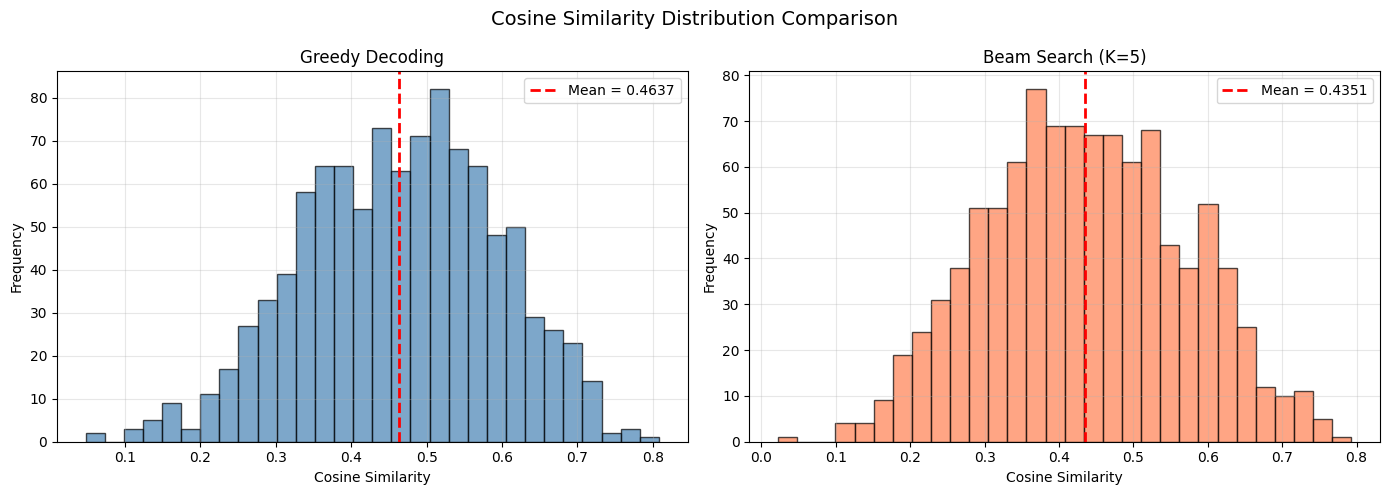

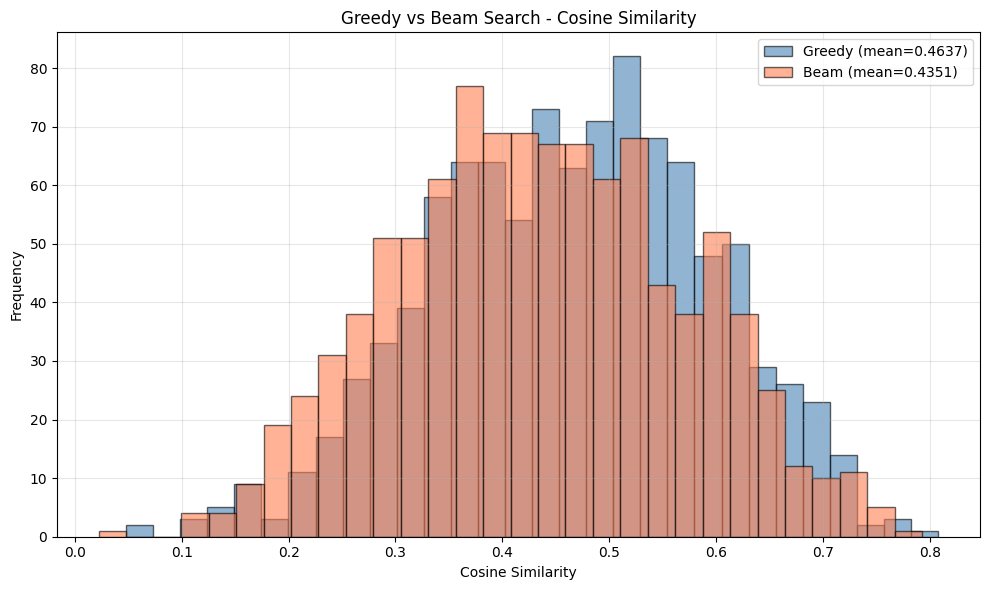

In [ ]:
# Calculate cosine similarity for both methods
# Using embedding layer from our trained decoder

print("Computing cosine similarity scores...")

# for greedy captions
cosine_greedy = []
for img_id in tqdm(test_ids, desc="Greedy cosine"):
    gen_cap = greedy_all_captions[img_id]
    refs = test_df[test_df['image_id'] == img_id]['cleaned_caption'].tolist()
    score = calculate_cosine(gen_cap, refs, vocab, embed_layer)
    cosine_greedy.append(score)

# for beam captions
cosine_beam = []
for img_id in tqdm(test_ids, desc="Beam cosine"):
    gen_cap = beam_all_captions[img_id]
    refs = test_df[test_df['image_id'] == img_id]['cleaned_caption'].tolist()
    score = calculate_cosine(gen_cap, refs, vocab, embed_layer)
    cosine_beam.append(score)

# print out the stats
print("\nCosine Similarity Stats:")
print(f"Greedy  - Mean: {np.mean(cosine_greedy):.4f}, Std: {np.std(cosine_greedy):.4f}")
print(f"Beam    - Mean: {np.mean(cosine_beam):.4f}, Std: {np.std(cosine_beam):.4f}")

# plot both histograms side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# greedy histogram
ax1.hist(cosine_greedy, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(np.mean(cosine_greedy), color='red', linestyle='--', linewidth=2,
            label=f'Mean = {np.mean(cosine_greedy):.4f}')
ax1.set_xlabel('Cosine Similarity')
ax1.set_ylabel('Frequency')
ax1.set_title('Greedy Decoding')
ax1.legend()
ax1.grid(True, alpha=0.3)

# beam histogram
ax2.hist(cosine_beam, bins=30, edgecolor='black', alpha=0.7, color='coral')
ax2.axvline(np.mean(cosine_beam), color='red', linestyle='--', linewidth=2,
            label=f'Mean = {np.mean(cosine_beam):.4f}')
ax2.set_xlabel('Cosine Similarity')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Beam Search (K={BEAM_SIZE})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Cosine Similarity Distribution Comparison', fontsize=14)
plt.tight_layout()
plt.show()

# also make an overlaid version to compare directly
plt.figure(figsize=(10, 6))
plt.hist(cosine_greedy, bins=30, alpha=0.6, color='steelblue', edgecolor='black',
         label=f'Greedy (mean={np.mean(cosine_greedy):.4f})')
plt.hist(cosine_beam, bins=30, alpha=0.6, color='coral', edgecolor='black',
         label=f'Beam (mean={np.mean(cosine_beam):.4f})')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Greedy vs Beam Search - Cosine Similarity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 7.2 Cosine Similarity Examples

We find examples with high and low cosine similarity scores.

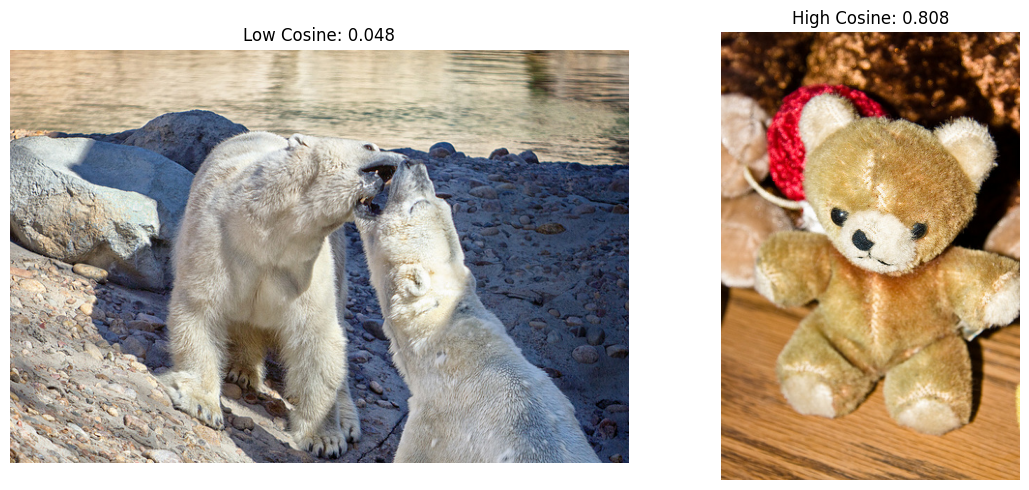

LOW COSINE EXAMPLE (Image 538737)
Greedy (cos=0.0479): a bear is standing in a field with a tree
Beam   (cos=0.0224): a brown bear sitting in a field

References:
  1. two polar bears standing next to each other
  2. two polar bears on rocks near a body of water
  3. two polar bears are on the rocks fighting
  4. two white bears on the rocky shore of some water
  5. two polar bears play fighting with each other

HIGH COSINE EXAMPLE (Image 139277)
Greedy (cos=0.8078): a teddy bear sitting on a table with a <unk>
Beam   (cos=0.7930): a teddy bear sitting on top of a table

References:
  1. a close up of a very small teddy bear
  2. a small brown teddy bear sitting on a table
  3. a brown teddy bear sitting on a wooden table next to a red ball
  4. a small teddy bear sitting on a wooden table
  5. a worn teddy bear sitting on a table top



In [40]:
# sort by cosine score to find best and worst examples
cosine_sorted = sorted(cosine_scores, key=lambda x: x['cosine'])

# get lowest and highest
low_ex = cosine_sorted[0]
high_ex = cosine_sorted[-1]

# show the two images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# low cosine image
img_path = os.path.join(IMAGE_DIR, f'{low_ex["image_id"]:012d}.jpg')
ax1.imshow(Image.open(img_path))
ax1.axis('off')
ax1.set_title(f'Low Cosine: {low_ex["cosine"]:.3f}')

# high cosine image
img_path = os.path.join(IMAGE_DIR, f'{high_ex["image_id"]:012d}.jpg')
ax2.imshow(Image.open(img_path))
ax2.axis('off')
ax2.set_title(f'High Cosine: {high_ex["cosine"]:.3f}')

plt.tight_layout()
plt.show()

# compare greedy vs beam for both examples
for label, ex in [("LOW", low_ex), ("HIGH", high_ex)]:
    img_id = ex['image_id']
    refs = test_df[test_df['image_id'] == img_id]['cleaned_caption'].tolist()
    
    # get both captions
    greedy_cap = greedy_all_captions[img_id]
    beam_cap = beam_all_captions[img_id]
    
    # calc cosine for both
    greedy_cos = calculate_cosine(greedy_cap, refs, vocab, embed_layer)
    beam_cos = calculate_cosine(beam_cap, refs, vocab, embed_layer)
    
    print("="*60)
    print(f"{label} COSINE EXAMPLE (Image {img_id})")
    print("="*60)
    print(f"Greedy (cos={greedy_cos:.4f}): {greedy_cap}")
    print(f"Beam   (cos={beam_cos:.4f}): {beam_cap}")
    print(f"\nReferences:")
    for i, ref in enumerate(refs[:5], 1):
        print(f"  {i}. {ref}")
    print()

## 8. Comparing BLEU and Cosine Similarity

### 8.1 Test Set Distribution of Scores

We evaluate both greedy and beam search decoding using BLEU and cosine similarity, comparing the resulting score distributions.

In [ ]:
# Function to rescale cosine similarity from [-1, 1] to [0, 1]
def rescale_cosine(score):
    return (score + 1) / 2

# Generate beam captions and calculate both metrics
print("Calculating metrics for Greedy and Beam Search...")

# Store results for both methods
results_greedy = []
results_beam = []

for img_id in tqdm(test_ids, desc="Processing"):
    refs = test_df[test_df['image_id'] == img_id]['cleaned_caption'].tolist()
    
    # Greedy results (already computed)
    greedy_cap = greedy_all_captions[img_id]
    greedy_bleu = calculate_bleu(greedy_cap, refs)
    greedy_cosine = calculate_cosine(greedy_cap, refs, vocab, embed_layer)
    greedy_cosine_scaled = rescale_cosine(greedy_cosine)
    
    results_greedy.append({
        'image_id': img_id,
        'caption': greedy_cap,
        'refs': refs,
        'bleu': greedy_bleu,
        'cosine': greedy_cosine,
        'cosine_scaled': greedy_cosine_scaled
    })
    
    # Beam results
    beam_cap = beam_all_captions[img_id]
    beam_bleu = calculate_bleu(beam_cap, refs)
    beam_cosine = calculate_cosine(beam_cap, refs, vocab, embed_layer)
    beam_cosine_scaled = rescale_cosine(beam_cosine)
    
    results_beam.append({
        'image_id': img_id,
        'caption': beam_cap,
        'refs': refs,
        'bleu': beam_bleu,
        'cosine': beam_cosine,
        'cosine_scaled': beam_cosine_scaled
    })

# Print summary statisticss
print("\n" + "="*70)
print("COMPARISON SUMMARY")
print("="*70)

print("\nGreedy Decoding:")
print(f"  Average BLEU:              {np.mean([r['bleu'] for r in results_greedy]):.4f}")
print(f"  Average Cosine (scaled):   {np.mean([r['cosine_scaled'] for r in results_greedy]):.4f}")

print("\nBeam Search Decoding:")
print(f"  Average BLEU:              {np.mean([r['bleu'] for r in results_beam]):.4f}")
print(f"  Average Cosine (scaled):   {np.mean([r['cosine_scaled'] for r in results_beam]):.4f}")

Calculating metrics for Greedy and Beam Search...


Processing: 100%|██████████| 1006/1006 [00:02<00:00, 335.96it/s]


COMPARISON SUMMARY

Greedy Decoding:
  Average BLEU:              0.1529
  Average Cosine (scaled):   0.7318

Beam Search Decoding:
  Average BLEU:              0.1704
  Average Cosine (scaled):   0.7175


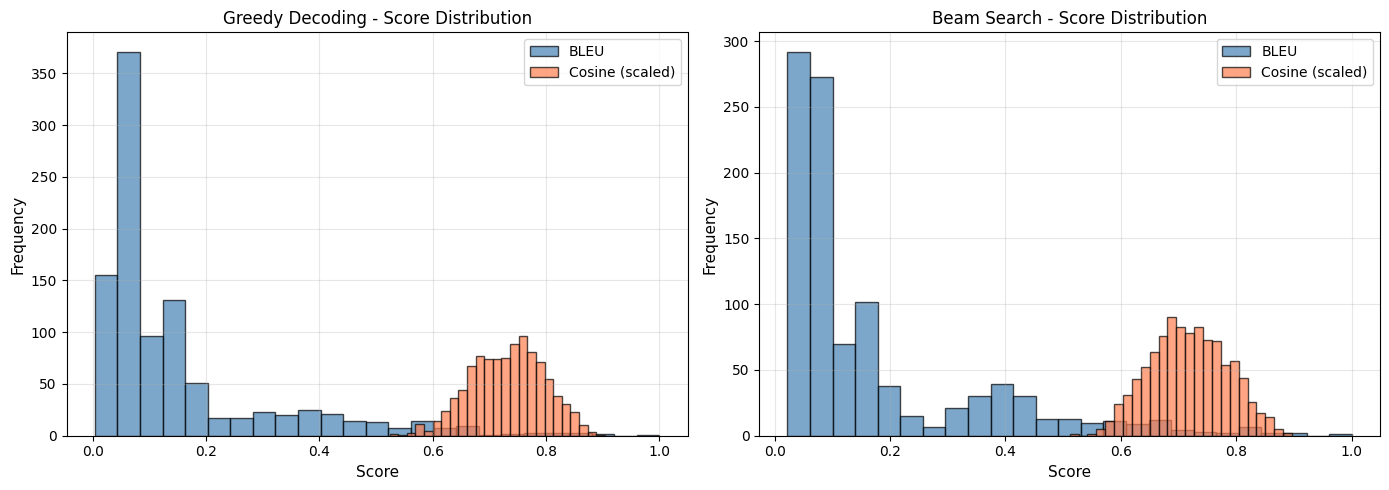

In [42]:
# Plot comparison of distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Greedy Decoding comparison
axes[0].hist([r['bleu'] for r in results_greedy], bins=25, alpha=0.7, 
             label='BLEU', color='steelblue', edgecolor='black')
axes[0].hist([r['cosine_scaled'] for r in results_greedy], bins=25, alpha=0.7, 
             label='Cosine (scaled)', color='coral', edgecolor='black')
axes[0].set_xlabel('Score', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Greedy Decoding - Score Distribution', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Beam Search comparison
axes[1].hist([r['bleu'] for r in results_beam], bins=25, alpha=0.7, 
             label='BLEU', color='steelblue', edgecolor='black')
axes[1].hist([r['cosine_scaled'] for r in results_beam], bins=25, alpha=0.7, 
             label='Cosine (scaled)', color='coral', edgecolor='black')
axes[1].set_xlabel('Score', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Beam Search - Score Distribution', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Discussion: BLEU vs Cosine Similarity for Image Captioning**

**Strengths and Weaknesses of Each Metric:**

*BLEU Score:*
- **Strengths:** Measures exact n-gram matches between generated and reference captions. Good at catching when the model uses the exact same phrases as humans. It's a standard metric so easy to compare with other papers.
- **Weaknesses:** Very strict - if I say "a dog running" and the reference says "a canine sprinting", BLEU gives 0 credit even though they mean the same thing. Also tends to give low scores overall (our average is only ~0.15-0.17 out of 1.0).

*Cosine Similarity:*
- **Strengths:** Captures semantic meaning through word embeddings. If "dog" and "canine" have similar vectors, it still gives a good score. More forgiving of paraphrasing and synonym use.
- **Weaknesses:** Ignores word order completely - "dog bites man" and "man bites dog" would get the same score. Averaging word vectors loses some information about sentence structure.

**What the Results Show:**

Looking at the histograms:
- BLEU scores (blue bars) are clustered near 0, with most scores between 0-0.2. This shows BLEU is harsh.
- Cosine scores (orange bars) are much higher, centered around 0.7-0.8. This means captions are semantically reasonable even when exact words don't match.

**Greedy vs Beam Search Comparison:**

| Metric | Greedy | Beam Search | Winner |
|--------|--------|-------------|--------|
| BLEU | 0.1529 | 0.1704 | Beam (+11%) |
| Cosine | 0.7318 | 0.7175 | Greedy (+2%) |

Interesting findings:
- Beam search has better BLEU (+11% improvement) because it explores multiple word sequences and picks ones with higher probability, which tend to use more common phrases that match references.
- But greedy has slightly better cosine similarity! This suggests greedy produces more semantically diverse captions, while beam search converges to "safe" common phrases.
- The trade-off makes sense: beam search optimizes for probability which correlates with common n-grams (good for BLEU), but this can reduce semantic richness (worse for cosine).

Neither metric alone tells the whole story. A caption could have low BLEU but high cosine (correct meaning, different words) or high BLEU but describe the wrong thing (lucky word matches). Using both together gives a better picture of caption quality.


### 8.2 Analysis of Individual Examples

We find examples where both metrics agree and disagree to understand their differences.

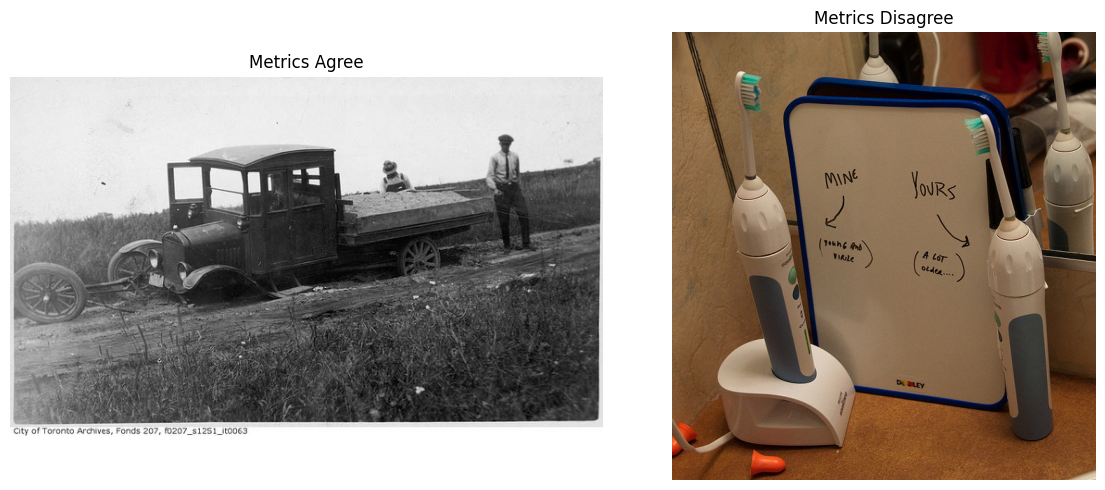

EXAMPLE 1: BLEU and Cosine AGREE
Image: 16486

Greedy: a train is parked on the side of a road
  -> BLEU: 0.6804, Cosine: 0.4000

Beam: a black and white photo of a train station
  -> BLEU: 0.0603, Cosine: 0.2611

References:
  1. two men with a vintage truck that is broken down
  2. a truck parked on the side of a road in a field
  3. an old image of a pickup truck broken down on the side of the road
  4. model t ford on side of dirt path with two men outside
  5. in an historic photo a car sits without wheels

EXAMPLE 2: BLEU and Cosine DISAGREE
Image: 514241

Greedy: a <unk> <unk> <unk> <unk> on a <unk> <unk> <unk>
  -> BLEU: 0.0251, Cosine: 0.6630

Beam: a black and white cat sitting on top of a table
  -> BLEU: 0.0267, Cosine: 0.1905

References:
  1. two toothbrushes next to each other in front of sign determining which belongs to who
  2. a couple of toothbrushes with a sign stating whos belongs to who
  3. two electric toothbrushes have a sign saying mine and yours
  4. two ele

In [53]:
# find one example where BLEU and cosine give similar scores
# and one where they really disagree

# first calculate the difference between BLEU and scaled cosine for each image
for r in results_greedy:
    r['diff'] = abs(r['bleu'] - r['cosine_scaled'])

# sort by difference
sorted_by_diff = sorted(results_greedy, key=lambda x: x['diff'])

# pick the most similar and most different
similar = sorted_by_diff[0]   # smallest gap
different = sorted_by_diff[-1]  # biggest gap

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(Image.open(os.path.join(IMAGE_DIR, f'{similar["image_id"]:012d}.jpg')))
ax1.axis('off')
ax1.set_title('Metrics Agree')

ax2.imshow(Image.open(os.path.join(IMAGE_DIR, f'{different["image_id"]:012d}.jpg')))
ax2.axis('off')
ax2.set_title('Metrics Disagree')

plt.tight_layout()
plt.show()

# now print the details for each
print("="*60)
print("EXAMPLE 1: BLEU and Cosine AGREE")
print("="*60)

img_id = similar['image_id']
refs = test_df[test_df['image_id'] == img_id]['cleaned_caption'].tolist()

# get captions
g_cap = greedy_all_captions[img_id]
b_cap = beam_all_captions[img_id]

# get scores
g_bleu = calculate_bleu(g_cap, refs)
b_bleu = calculate_bleu(b_cap, refs)
g_cos = calculate_cosine(g_cap, refs, vocab, embed_layer)
b_cos = calculate_cosine(b_cap, refs, vocab, embed_layer)

print(f"Image: {img_id}")
print(f"\nGreedy: {g_cap}")
print(f"  -> BLEU: {g_bleu:.4f}, Cosine: {g_cos:.4f}")
print(f"\nBeam: {b_cap}")
print(f"  -> BLEU: {b_bleu:.4f}, Cosine: {b_cos:.4f}")
print(f"\nReferences:")
for i, ref in enumerate(refs[:5], 1):
    print(f"  {i}. {ref}")

print("\n" + "="*60)
print("EXAMPLE 2: BLEU and Cosine DISAGREE")
print("="*60)

img_id = different['image_id']
refs = test_df[test_df['image_id'] == img_id]['cleaned_caption'].tolist()

g_cap = greedy_all_captions[img_id]
b_cap = beam_all_captions[img_id]

g_bleu = calculate_bleu(g_cap, refs)
b_bleu = calculate_bleu(b_cap, refs)
g_cos = calculate_cosine(g_cap, refs, vocab, embed_layer)
b_cos = calculate_cosine(b_cap, refs, vocab, embed_layer)

print(f"Image: {img_id}")
print(f"\nGreedy: {g_cap}")
print(f"  -> BLEU: {g_bleu:.4f}, Cosine: {g_cos:.4f}")
print(f"\nBeam: {b_cap}")
print(f"  -> BLEU: {b_bleu:.4f}, Cosine: {b_cos:.4f}")
print(f"\nReferences:")
for i, ref in enumerate(refs[:5], 1):
    print(f"  {i}. {ref}")


## Discussion and Analysis

### Example 1 – Metrics Agree (Image 16486)

In this example, both evaluation metrics give consistent signals about caption quality. The greedy caption achieved a BLEU score of 0.6804 and a cosine similarity of 0.400, which indicates relatively strong agreement between lexical overlaped and semantic similarity.. The beam caption, on the other hand, shows much lower scores (BLEU = 0.0603, cosine = 0.2611).

The greedy caption includes phrases such as *“parked on the side of a road”*, which closely match several reference captions like *“a truck parked on the side of a road in a field”*. Because of this overlap, BLEU rewards the caption with a high score. At the same time, cosine similarity also reflects moderate semantic alignment, since both the generated caption and the references describe a stationary vehicle in an outdoor, historical setting.

Even though the object is slightly misclassified as a “train” instead of a “truck” both metrics still agree that the overall description is reasonably accurate. This examplle demonstrates a situation where surface-level word overlap and semantic meaning lead to the same evaluation outcome..


### Example 2 – Metrics Disagree (Image 514241)

This example clearly shows a disagreement between BLEU and cosine similarity scores.The greedy caption has a very low BLEU score of 0.0251, but a high cosine similarity of 0.6630. The low BLEU score is mainly caused by the presence of multiple `<unk>` token, which prevent meaningful n=gram matches with the reference captions.

BLEU is strict and relies on exact word matches, so these unknown tokens severely reduce its score. However, cosine similarity is based on embeddings and overall meaning which explains why it still produces a relatively high value. This suggests that, at a semantic level, the model may still be capturing some information related to the scene, even though the output text is not readable.

In contrast, the beam caption is fluent and grammatically correct but semantically incorrect, describing *“a black and white cat sitting on top of a table..”* This results in slightly higher BLEU (0.0267) than the greedy caption, but a much lower cosine similarity (0.1905), since the meaning does not align with the references about toothbrushes and ownership signs.


### Takeaway

These examples highlight why using a single metric is not sufficient for evaluating image caption. BLEU is highly sensitive to exact wording and vocabulary issues, while cosine similarity is more tolerant and focuses on semantic meaning. The toothbrush example clearly shows how cosine similarity can remain high even when the generated caption contains errors or unknown tokens.

Therefore combining BLEU and cosine similarity provides a more complete and reliable evaluation, as each metric captures a different dimension of caption quality.